In [69]:
import numpy as np
import pandas as pd
from scipy import stats
import datetime

# Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pylab
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('fivethirtyeight')
%matplotlib inline

# Pre-processing Packages
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA 

# String Cleaning and NLP Packages
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textstat.textstat import textstat

# Clustering Packages
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

# Modeling Packages
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### EXECUTIVE SUMMARY

{}

### ACKNOWLEDGEMENTS

This project would not have been possible without the support and encouragement of the Hoppers cohort instructors, Alex Combs, Michael Roman, Phillippa Thomson, and Rebecca Vitale. I am also indebted to my fellow cohort members for their constructive feedback.


### DATA

The data were obtained from the House of Representatives and Senate sections of the online manifestation of the Congressional Record (CR), a daily publication of the Government Publishing Office which covers proceedings and debates of the United States Congress in their entirety. Given my interest in analyzing remarks made on the House and Senate floors, I ignored the Daily Digest and Extensions of Remarks sections because they recap the previous day’s events and print Representatives’ “additional statements not actually delivered on the House floor,” respectively. CR entries are available on their webpages in TXT and PDF form. They can be accessed through quick/advanced search forms, a query builder, SOLR query syntax in the command line, email alerts, and Apple App Store applications, but the legislative branch of our federal government does not provide a way to easily export the entries to a format that is conducive to data analysis. Thus, I used John Campbell’s Concord scraper to web scrape each entry within a specified timeframe. After defining the scrape’s parameters, the spider was unleashed on the Congressional Record website to extract data from each entry, one year at a time. This time-consuming process yielded .json files for 2010 through March 2017, but for the sake of manageability, I decided to examine the most recent completed Congress, number 114, which convened on January 3, 2015 and concluded two years later. Once the output files were stored in a single pandas DataFrame, there were 34,889 rows and eight columns consisting of the following information for each CR entry: date, Congress (number), session, issue, volume, start page, end page, title, and text. 
Cleaning the data was more grueling than I anticipated. Converting each column to its proper type and removing the few values corresponding to the 113th were easy enough, but winnowing the dataset to reduce noise required a considerable amount of effort and patience. Many CR entries could not be used because they (1) described ceremonial/procedural actions (e.g., recitations of prayers and the Pledge of Allegiance, declaration of morning business, announcement of adjournment, etc.); (2) printed the complete text of government documents (e.g., Congressional Budget Office cost estimates, arms sales notifications, submitted resolutions, etc.), or (3) were not remarks made by Representatives or Senators (e.g., content authored/delivered by President Obama, the Office of the Clerk of the House of Representatives, some government agency, etc.). The CR makes a distinction between remarks delivered as a member of Congress and   


In [2]:
# years = ['15', '16']
# file_path_template = ['/Users/sidraahmad/DSI-NYC-4/capstone/concord/congress_gov/logs_and_output/output_', '.json']

# for year in years:
#     json_file = file_path_template[0] + year + file_path_template[1]
#     with open(json_file, 'r') as output:
#         json_data = [json.loads(line) for line in output]

In [3]:
# json_15 = '/Users/sidraahmad/DSI-NYC-4/capstone/concord/congress_gov/logs_and_output/output_15.json'
# json_16 = '/Users/sidraahmad/DSI-NYC-4/capstone/concord/congress_gov/logs_and_output/output_16.json'

# #master_df = pd.DataFrame(columns = ['congress', 'date', 'end_page', 'issue', 'session', 'start_page', 'text', 'title', 'url', 'volume'])

# with open(json_15, 'r') as output_15:
#     json_15_data = [json.loads(line) for line in output_15]
    
# with open(json_16, 'r') as output_16:
#     json_16_data = [json.loads(line) for line in output_16]  
    
# master_df = pd.concat([pd.DataFrame(json_15_data), pd.DataFrame(json_16_data)], axis = 0)

In [4]:
# congress_114 = master_df

In [5]:
# congress_114 = congress_114.drop('url', axis = 1)

In [6]:
# DO NOT RELOAD!
# congress_114.to_csv('XX/Users/sidraahmad/DSI-NYC-4/capstone/datasets/congress_114_notclean_utf8.csv', index = False, encoding = 'utf-8')

In [7]:
congress_114 = pd.read_csv('/Users/sidraahmad/DSI-NYC-4/capstone/datasets/congress_114_notclean_utf8.csv')

In [8]:
congress_114.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34889 entries, 0 to 34888
Data columns (total 9 columns):
congress      34889 non-null int64
date          34889 non-null object
end_page      34889 non-null object
issue         34889 non-null int64
session       34889 non-null int64
start_page    34889 non-null object
text          34889 non-null object
title         34889 non-null object
volume        34889 non-null int64
dtypes: int64(4), object(5)
memory usage: 2.4+ MB


In [9]:
congress_114['congress'] = congress_114['congress'].astype('float')
congress_114['issue'] = congress_114['issue'].astype('float')
congress_114['session'] = congress_114['session'].astype('float')
congress_114['volume'] = congress_114['volume'].astype('float')

congress_114['date'] = congress_114['date'].apply(lambda x: pd.to_datetime(x))

In [10]:
congress_114 = congress_114[congress_114.congress != 113.0]

In [11]:
congress_114['congress'].value_counts()

114.0    34856
Name: congress, dtype: int64

In [12]:
congress_114 = congress_114.drop('congress', axis = 1)

In [13]:
congress_114.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34856 entries, 2 to 34888
Data columns (total 8 columns):
date          34856 non-null datetime64[ns]
end_page      34856 non-null object
issue         34856 non-null float64
session       34856 non-null float64
start_page    34856 non-null object
text          34856 non-null object
title         34856 non-null object
volume        34856 non-null float64
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 2.4+ MB


In [14]:
# congress_114.loc[congress_114['title'].str.contains(''), :] (indexing)
# congress_114['title'].str.contains('').value_counts() (value Counts)

In [15]:
# Don't drop 'LEGISLATIVE PROGRAM', 'VOTE EXPLANATION', 'PRESIDENTIAL NOMINATIONS', 'EXECUTIVE CALENDAR OBJECTION',
# 'EXECUTIVE NOMINATIONS', 'JUDICIAL NOMINATIONS', 'RESOLUTIONS SUBMITTED TODAY', 

trash = ['House of Representatives', 'Senate', 'PRAYER', 'PLEDGE OF ALLEGIANCE', 'RECESS', 'LEAVE OF ABSENCE', 
         'MEMORIALS', 'REAPPOINTMENT', 'SUBMISSION OF CONCURRENT AND SENATE RESOLUTIONS', 'ADJOURNMENT', 
         'TEXT OF AMENDMENTS', 'MORNING BUSINESS', 'PRESIDENTIAL MESSAGE', 'ENROLLED BILL', 'PRO TEMPORE',
         'SENATE CONCURRENT RESOLUTION', 'WITHDRAWAL', 'THE JOURNAL', 'HOUR OF MEETING', 'MORNING-HOUR',
         'EXPENDITURES BY THE OFFICE OF GENERAL COUNSEL', 'PUBLIC BILLS AND RESOLUTIONS', 'CLOTURE MOTION',
         'INTRODUCTION OF BILLS AND JOINT RESOLUTIONS', 'DELETIONS OF', 'ORDER OF PROCEDURE', 'GENERAL LEAVE',
         'RESERVATION OF LEADER TIME', 'AUTHORITY FOR COMMITTEES TO MEET', 'EXECUTIVE SESSION',
         'EXPENDITURE REPORTS CONCERNING OFFICIAL FOREIGN TRAVEL', 'RESOLUTIONS SUBMITTED TODAY',
         'CONGRESSIONAL EARMARKS, LIMITED TAX BENEFITS, OR LIMITED TARIFF BENEFITS', 'LEGISLATIVE SESSION',
         'PRIVILEGES OF THE FLOOR', 'AMENDMENTS SUBMITTED AND PROPOSED', 'SUBMITTED RESOLUTIONS',
         'PRIVATE BILLS AND RESOLUTIONS', 'PUBLICATION OF COMMITTEE RULES', 'ARMS SALES NOTIFICATION',
         'The House met at 2 p.m. and was called to order by the Speaker pro tempore (Mr. Holding).',
         'BUDGET OF THE UNITED STATES GOVERNMENT FOR FISCAL YEAR 2016--PM 3', 'BUDGETARY REVISIONS',
         'CBO COST ESTIMATE', 'SUBCOMMITTEE ASSIGNMENTS', 'ARMS SALES NOPTIFICATION', 'IN MEMORY OF',
         'TRIBUTES TO DEPARTING SENATORS', 'MEASURE INDEFINITELY POSTPONED--H. CON. RES. 91',
         'REMEMBERING', 'MOMENT OF SILEENCE', 'COMMENDING', 'CONGRATULATING', 'MEASURE INDEFINITELY POSTPONED',
         '(APPOINTMENTS AUTHORITY)', '^(APPOINTMENT)S*$', 'ADDITIONAL (CO)*SPONSORS', '^NOMINATIONS$',
         '(MEASURE)S* PLACED ON THE CALENDAR', '(APPOINTMENT OF MEMBER TO)', '(REPORT)S* OF COMMITTEE', 
         '(SENATE RESOLUTION\s\d*)', '^(RECOGNITION OF)', 'EXECUTIVE.*COMMUNICATIONS', '^(PROGRAM)$',
         '(Constitutional Authority Statement).*', '((MESSAGE)S* FROM THE).*', '(DISCHARGED NOMINATION)S*',
         '^PETITIONS', '(DISCHARGE PETITION).*', '(REMOVAL OF NAME)', '(THE CLERK)[^.]', '^CONFIRMATION$',
         '(MESSAGE)S* REFERRED', '(MEASURE)S* REFERRED', '(SENATE BILL)S* REFERRED', '^EXECUTIVE CALENDAR$',
         '(MEASURE)S* READ THE FIRST TIME', '(UNANIMOUS CONSENT AGREEMENT)', '^AMENDMENTS$', '^(PERMISSION)',
         '(COMMUNICATION FROM)', '(ANNOUNCEMENT)S* BY THE SPEAKER', '(BILL)S* PRESENTED TO THE PRESIDENT',
         '^CONFIRMATIONS$', 'AUTHORIZING USE OF.*CAPITOL GROUNDS', '^(REPORT ON)', '^(TRIBUTE TO)',
         '^(RECOGNIZING)', '^HONORING', '^ORDER', 
         '(BUDGET COMMITTEE COST ESTIMATE)',
        ]

for trashlet in trash:
    take_out = congress_114['title'].str.contains(trashlet)
    congress_114 = congress_114[~take_out]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [16]:
congress_114.shape

(11718, 8)

In [17]:
congress_114 = congress_114.reset_index(drop = True)

In [18]:
congress_114['text'] = [x.replace('\n', '') for x in congress_114['text']]
congress_114['text'] = [x.strip() for x in congress_114['text']]

In [19]:
# TEXT-STRIPPING
# Internal page citations: '(\[\[Page \w*\d*\]\])'
# Header: '^(\[.*\])\s*'
# Terminal line: '(\s*____________________)'
# Time: '(\s*{time}\s*\d*)'
# Parentheses and contents: '\(.*?\)'
# Extra spaces: '\s\s+'

In [20]:
congress_114['text'] = congress_114['text'].apply(lambda x: re.sub(r'(\[\[Page \w*\d*\]\])', ' ', x))
congress_114['text'] = congress_114['text'].apply(lambda x: re.sub(r'^(\[.*\])\s*', '', x))
congress_114['text'] = congress_114['text'].apply(lambda x: re.sub(r'(\s*____________________)', '', x))
congress_114['text'] = congress_114['text'].apply(lambda x: re.sub(r'(\s*{time}\s*\d*)', '', x))
congress_114['text'] = congress_114['text'].apply(lambda x: re.sub(r'\(.*?\)', '', x))
congress_114['text'] = congress_114['text'].apply(lambda x: re.sub(r'\s\s+', ' ', x))

In [21]:
for i in range(len(congress_114)):
    title = congress_114.loc[i, 'title']
    if title not in congress_114.loc[i, 'text']:
        congress_114.loc[i, 'trash'] = 1
    else:
        congress_114.loc[i, 'trash'] = 0

In [22]:
congress_114['trash'].value_counts()

0.0    10147
1.0     1571
Name: trash, dtype: int64

In [23]:
congress_114 = congress_114[congress_114.trash != 1]

In [24]:
take_out = congress_114['text'].str.contains('RULES OF PROCEDURE')
congress_114 = congress_114[~take_out]

In [25]:
take_out = congress_114['text'].str.contains(
    'The PRESIDING OFFICER laid before the Senate the following message from'
                                            )
congress_114 = congress_114[~take_out]

In [26]:
congress_114 = congress_114.drop('trash', axis = 1)
congress_114 = congress_114.reset_index(drop = True)
congress_114.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10122 entries, 0 to 10121
Data columns (total 8 columns):
date          10122 non-null datetime64[ns]
end_page      10122 non-null object
issue         10122 non-null float64
session       10122 non-null float64
start_page    10122 non-null object
text          10122 non-null object
title         10122 non-null object
volume        10122 non-null float64
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 632.7+ KB


In [27]:
# KEEP THIS AT ALL COSTS!
def speaker(x):
    try:
        find = re.findall(r'Mr*s*\.\s(?!Speaker|President|Chair|Chairman|Chairwoman|Leader|Majority Leader|Minority Leader)\w*\.', x)
        return [i for i in zip([0] + find, re.split(r'Mr*s*\.\s(?!Speaker|President|Chair|Chairman|Chairwoman|Leader|Majority Leader|Minority Leader)\w*\.', x))]
    except:
        return np.nan

rows = []
for i in range(len(congress_114)):
    piecelet = speaker(congress_114.loc[i, 'text'])
    for j in range(1, len(piecelet) + 1):
        try:
            entry = (piecelet[0], piecelet[j])
            rows.append(entry)
        except:
            rows.append((np.nan, np.nan))

df = pd.DataFrame(rows)

In [28]:
df = df.dropna()
df = df.reset_index(drop = True)

In [29]:
title = []

for x in df[0]:
    what = x[1]
    title.append(what)

df['title'] = title

In [30]:
speaker = []

for x in df[1]:
    who = x[0]
    speaker.append(who)

df['speaker'] = speaker

In [31]:
remark = []

for x in df[1]:
    quote = x[1]
    remark.append(quote)

df['remark'] = remark

In [32]:
df.head()

,0,1,title,speaker,remark
0,"(0, DISASTER ASSISTANCE FAIRNESS AND ACCOUNTAB...","(Mr. MacARTHUR., Mr. Speaker, on October 29 o...",DISASTER ASSISTANCE FAIRNESS AND ACCOUNTABILIT...,Mr. MacARTHUR.,"Mr. Speaker, on October 29 of 2012, Super Sto..."
1,"(0, MATTERS OF GRAVE CONCERN TO AMERICA The SP...","(Mr. ROHRABACHER., Mr. Speaker, today, I rise...",MATTERS OF GRAVE CONCERN TO AMERICA The SPEAKE...,Mr. ROHRABACHER.,"Mr. Speaker, today, I rise to have a discussi..."
2,"(0, TERRITORIAL VOTING RIGHTS )","(Ms. PLASKETT., Mr. Speaker, this month, as w...",TERRITORIAL VOTING RIGHTS,Ms. PLASKETT.,"Mr. Speaker, this month, as we pay homage to ..."
3,"(0, LEAH CHASE, THE QUEEN OF CREOLE CUISINE )","(Mr. RICHMOND., Mr. Speaker, today I rise in ...","LEAH CHASE, THE QUEEN OF CREOLE CUISINE",Mr. RICHMOND.,"Mr. Speaker, today I rise in the spirit of Bl..."
4,"(0, REFORM OUR TRADE POLICIES )","(Ms. KAPTUR., Mr. Speaker, I rise today to ta...",REFORM OUR TRADE POLICIES,Ms. KAPTUR.,"Mr. Speaker, I rise today to talk about the m..."


In [33]:
df['remark'] = df['remark'].apply(lambda x: re.sub(
        r'There being no objection, the material was ordered to be printed in the Record, as follows:.*', '', x))

In [34]:
take_out = df['speaker'].str.contains('Mr*s*\.\s[A-Z]+[a-z]{3,}\.')
df = df[~take_out]

In [35]:
value_counts = df['speaker'].value_counts() # Specific column 
take_out = value_counts[value_counts <= 9].index
df['speaker'] = df['speaker'].replace(take_out, np.nan)

In [36]:
df['speaker'].nunique()

389

In [37]:
df = df.drop([0, 1], axis = 1)
df = df.dropna()
df = df.reset_index(drop = True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24491 entries, 0 to 24490
Data columns (total 3 columns):
title      24491 non-null object
speaker    24491 non-null object
remark     24491 non-null object
dtypes: object(3)
memory usage: 574.1+ KB


In [39]:
# DO NOT RELOAD!
# df.to_csv('/Users/sidraahmad/DSI-NYC-4/capstone/datasets/df_semiclean_utf8_0416.csv', index = False, encoding = 'utf-8')

In [40]:
df = pd.read_csv('/Users/sidraahmad/DSI-NYC-4/capstone/datasets/df_semiclean_utf8_0416.csv')

In [41]:
df.head()

,title,speaker,remark
0,DISASTER ASSISTANCE FAIRNESS AND ACCOUNTABILIT...,Mr. MacARTHUR.,"Mr. Speaker, on October 29 of 2012, Super Sto..."
1,MATTERS OF GRAVE CONCERN TO AMERICA The SPEAKE...,Mr. ROHRABACHER.,"Mr. Speaker, today, I rise to have a discussi..."
2,TERRITORIAL VOTING RIGHTS,Ms. PLASKETT.,"Mr. Speaker, this month, as we pay homage to ..."
3,"LEAH CHASE, THE QUEEN OF CREOLE CUISINE",Mr. RICHMOND.,"Mr. Speaker, today I rise in the spirit of Bl..."
4,REFORM OUR TRADE POLICIES,Ms. KAPTUR.,"Mr. Speaker, I rise today to talk about the m..."


In [42]:
# MORE TEXT-STRIPPING
df['remark'] = df['remark'].apply(lambda x: re.sub(r'The text of the \w* is as follows:.*', '', x))
df['remark'] = df['remark'].apply(lambda x: re.sub(r'The Clerk read the title of the bill\..*', '', x))
df['remark'] = df['remark'].apply(lambda x: re.sub(r'There being no objection, the text of the bill was ordered to be printed in the Record, as follows:.*', '', x))
df['remark'] = df['remark'].apply(lambda x: re.sub(r'The PRESIDING OFFICER\..*', '', x))
df['remark'] = df['remark'].apply(lambda x: re.sub(r'The CHAIR\..*', '', x))
df['remark'] = [x.strip() for x in df['remark']]

In [43]:
df['remark'] = [x.decode('utf-8') for x in df['remark']]

In [44]:
le = LabelEncoder()
df['speaker_encoded'] = le.fit_transform(df['speaker'])

In [45]:
df['word_count'] = df['remark'].str.split().str.len()

In [46]:
sia = SentimentIntensityAnalyzer()
df['scores'] = df['remark'].apply(lambda x: sia.polarity_scores(x))

In [47]:
df = df.join(pd.DataFrame(df['scores'].to_dict()).T)

In [48]:
df = df.drop('scores', axis = 1)
df.head()

,title,speaker,remark,speaker_encoded,word_count,compound,neg,neu,pos
0,DISASTER ASSISTANCE FAIRNESS AND ACCOUNTABILIT...,Mr. MacARTHUR.,"Mr. Speaker, on October 29 of 2012, Super Stor...",189,862,-0.9866,0.124,0.788,0.088
1,MATTERS OF GRAVE CONCERN TO AMERICA The SPEAKE...,Mr. ROHRABACHER.,"Mr. Speaker, today, I rise to have a discussio...",241,6189,-0.9995,0.143,0.726,0.131
2,TERRITORIAL VOTING RIGHTS,Ms. PLASKETT.,"Mr. Speaker, this month, as we pay homage to t...",378,214,0.9501,0.006,0.907,0.087
3,"LEAH CHASE, THE QUEEN OF CREOLE CUISINE",Mr. RICHMOND.,"Mr. Speaker, today I rise in the spirit of Bla...",239,274,0.9889,0.018,0.843,0.139
4,REFORM OUR TRADE POLICIES,Ms. KAPTUR.,"Mr. Speaker, I rise today to talk about the mi...",363,220,0.7269,0.080,0.807,0.113


In [49]:
df['diff'] = df['pos'] - df['neg']

In [53]:
df['reading_ease'] = df['remark'].apply(lambda x: textstat.flesch_reading_ease(x))

In [54]:
df['grade_level'] = df['remark'].apply(lambda x: textstat.flesch_kincaid_grade(x))

In [56]:
# DO NOT RELOAD!
# df.to_csv('/Users/sidraahmad/DSI-NYC-4/capstone/datasets/df_word_features_0416.csv', index = False, encoding = 'utf-8')

In [2]:
df = pd.read_csv('/Users/sidraahmad/DSI-NYC-4/capstone/datasets/df_word_features_0416.csv')
df.head()

,title,speaker,remark,speaker_encoded,word_count,compound,neg,neu,pos,diff,reading_ease,grade_level
0,DISASTER ASSISTANCE FAIRNESS AND ACCOUNTABILIT...,Mr. MacARTHUR.,"Mr. Speaker, on October 29 of 2012, Super Stor...",189,862,-0.9866,0.124,0.788,0.088,-0.036,62.68,8.7
1,MATTERS OF GRAVE CONCERN TO AMERICA The SPEAKE...,Mr. ROHRABACHER.,"Mr. Speaker, today, I rise to have a discussio...",241,6189,-0.9995,0.143,0.726,0.131,-0.012,66.07,9.5
2,TERRITORIAL VOTING RIGHTS,Ms. PLASKETT.,"Mr. Speaker, this month, as we pay homage to t...",378,214,0.9501,0.006,0.907,0.087,0.081,56.59,11.1
3,"LEAH CHASE, THE QUEEN OF CREOLE CUISINE",Mr. RICHMOND.,"Mr. Speaker, today I rise in the spirit of Bla...",239,274,0.9889,0.018,0.843,0.139,0.121,61.67,9.1
4,REFORM OUR TRADE POLICIES,Ms. KAPTUR.,"Mr. Speaker, I rise today to talk about the mi...",363,220,0.7269,0.080,0.807,0.113,0.033,59.30,8.0


In [3]:
# Female = 1; Male = 0
for i in range(len(df)): 
    if 'Ms.' in df.loc[i, 'speaker']:
        df.loc[i, 'gender'] = 1
    elif 'Mrs.' in df.loc[i, 'speaker']:
        df.loc[i, 'gender'] = 1
    elif 'Mr.' in df.loc[i, 'speaker']:
        df.loc[i, 'gender'] = 0
    else:
        df.loc[i, 'gender'] == '?'

In [4]:
df['gender'].value_counts()

0.0    20730
1.0     3761
Name: gender, dtype: int64

In [5]:
df['party'] = np.nan

In [6]:
# DROPPING'Mr. PETERS.', 'Mr. KING', 'Mr. REED.', 'Mr. SCOTT.', and 'Mr. JOHNSON.' 
# because multiple politicians have those names.
speakers = {
    'Mr. MacARTHUR.': 'R', 'Mr. ROHRABACHER.': 'R', 'Ms. PLASKETT.': 'D',
    'Mr. RICHMOND.': 'D', 'Ms. KAPTUR.': 'D', 'Mr. HOYER.': 'D', 'Mr. McCARTHY.': 'R',
    'Mr. PASCRELL.': 'D', 'Mr. KILDEE.': 'D', 'Mr. McKINLEY.': 'R', 'Mr. FORTENBERRY.': 'R',
    'Ms. McSALLY.': 'R', 'Mr. McCAUL.': 'R', 'Mr. PERRY.': 'R', 'Mr. KATKO.': 'R',
    'Mr. PALMER.': 'R', 'Mr. DENHAM.': 'R', 'Mr. HIGGINS.': 'D', 'Mr. CLYBURN.': 'D',
    'Mr. PAULSEN.': 'R', 'Mr. POLIS.': 'D', 'Mr. SCHRADER.': 'D', 'Ms. KUSTER.': 'D',
    'Mr. BENISHEK.': 'R', 'Mr. FOSTER.': 'D', 'Mr. PITTS.': 'R', 'Mr. CARNEY.': 'D',
    'Mr. WALBERG.': 'R', 'Mr. CICILLINE.': 'D', 'Mr. VEASEY.': 'D', 'Mr. PITTENGER.': 'R',
    'Mr. PALLONE.': 'D', 'Mr. COFFMAN.': 'R', 'Mrs. BEATTY.': 'D', 'Mrs. WALORSKI.': 'R',
    'Mr. QUIGLEY.': 'D', 'Mr. KILMER.': 'D', 'Mr. JEFFRIES.': 'D', 'Mr. PIERLUISI.': 'D',
    'Mr. BLUMENAUER.': 'D', 'Mr. ROSS.': 'R', 'Mr. GOHMERT.': 'R', 'Mr. GARAMENDI.': 'D',
    'Mr. WELCH.': 'D', 'Mr. TONKO.': 'D', 'Mr. SESSIONS.': 'R', 'Mr. BECERRA.': 'D',
    'Ms. SCHAKOWSKY.': 'D', 'Ms. GRAHAM.': 'D', 'Mr. TAKANO.': 'D', 'Mr. ISRAEL.': 'D',
    'Mr. TROTT.': 'R', 'Ms. HAHN.': 'D', 'Mr. POLIQUIN.': 'R', 'Mr. HIMES.': 'D',
    'Mr. YODER.': 'R', 'Mr. CARTWRIGHT.': 'D', 'Mr. McCLINTOCK.': 'R', 'Mr. McGOVERN.': 'D',
    'Mr. PAYNE.': 'D', 'Mr. BUTTERFIELD.': 'D', 'Mr. RANGEL.': 'D', 'Mr. LaMALFA.': 'R',
    'Ms. NORTON.': 'D', 'Ms. FOXX.': 'R', 'Mr. BARRASSO.': 'R', 'Mr. DURBIN.': 'D',
    'Mr. ALEXANDER.': 'R', 'Mr. CORNYN.': 'R', 'Mr. HATCH.': 'R', 'Mr. BLUMENTHAL.': 'D',
    'Mr. MENENDEZ.': 'D', 'Ms. MURKOWSKI.': 'R', 'Mr. MORAN.': 'R', 'Mr. McCONNELL.': 'R',
    'Mrs. FEINSTEIN.': 'D', 'Mr. VITTER.': 'R', 'Mr. BROWN.': 'D', 'Mrs. BOXER.': 'D',
    'Mr. ISAKSON.': 'R', 'Mr. SANDERS.': 'I', 'Mr. UDALL.': 'D', 'Mr. ROBERTS.': 'R',
    'Mr. THUNE.': 'R', 'Ms. MIKULSKI.': 'D', 'Mr. BOOZMAN.': 'R', 'Mr. CARDIN.': 'D',
    'Mr. CARPER.': 'D', 'Mrs. BLACK.': 'R', 'Mr. McHENRY.': 'R',
    'Mr. ASHFORD.': 'D', 'Mr. DOLD.': 'R', 'Mrs. CAPPS.': 'D', 'Ms. DeLAURO.': 'D',
    'Mr. POCAN.': 'D', 'Ms. ADAMS.': 'D', 'Mr. YARMUTH.': 'D', 'Mr. NOLAN.': 'D',
    'Mr. UPTON.': 'R', 'Mr. WALKER.': 'R', 'Mr. MEADOWS.': 'R', 'Mr. GOODLATTE.': 'R',
    'Mr. SENSENBRENNER.': 'R', 'Mrs. WAGNER.': 'R', 'Mr. FARENTHOLD.': 'R',
    'Mrs. NOEM.': 'R', 'Mr. McDERMOTT.': 'D', 'Ms. TITUS.': 'D',
    'Mr. GUINTA.': 'R', 'Mr. WENSTRUP.': 'R', 'Mr. FITZPATRICK.': 'R',
    'Mrs. BLACKBURN.': 'R', 'Mr. YOHO.': 'R', 'Mrs. HARTZLER.': 'R', 'Mrs. COMSTOCK.': 'R',
    'Ms. BASS.': 'D', 'Mr. LANGEVIN.': 'D', 'Mr. KLINE.': 'R', 'Mr. ROYCE.': 'R',
    'Mr. BURGESS.': 'R', 'Mr. TAKAI.': 'D', 'Mr. GRASSLEY.': 'R', 'Mr. REID.': 'D',
    'Mr. CORKER.': 'R', 'Ms. CANTWELL.': 'D', 'Mr. HOEVEN.': 'R', 'Mr. MARKEY.': 'D',
    'Mrs. FISCHER.': 'R', 'Mr. FRANKEN.': 'D', 'Mr. MURPHY.': 'D', 'Mr. SCHUMER.': 'D',
    'Mr. WHITEHOUSE.': 'D', 'Ms. KLOBUCHAR.': 'D', 'Mr. BLUNT.': 'R', 'Mr. WYDEN.': 'D',
    'Ms. HEITKAMP.': 'D', 'Mr. INHOFE.': 'R', 'Mr. HULTGREN.': 'R', 'Ms. BONAMICI.': 'D',
    'Mr. JOLLY.': 'R', 'Mr. BYRNE.': 'R', 'Mr. STUTZMAN.': 'R', 'Mr. STEWART.': 'R',
    'Mr. ROTHFUS.': 'R', 'Mr. HUELSKAMP.': 'R', 'Mr. LATTA.': 'R', 'Mr. MICA.': 'R',
    'Mr. LAMBORN.': 'R', 'Mr. CONAWAY.': 'R', 'Mr. MESSER.': 'R', 'Mr. MULLIN.': 'R',
    'Mr. BEYER.': 'D', 'Ms. LEE.': 'D', 'Mr. NEWHOUSE.': 'R', 'Ms. FUDGE.': 'D',
    'Mr. POMPEO.': 'R', 'Mr. JONES.': 'R', 'Mr. ENGEL.': 'D', 'Ms. PELOSI.': 'D',
    'Mr. COHEN.': 'D', 'Mr. LEAHY.': 'D', 'Mr. BENNET.': 'D', 'Mr. BOOKER.': 'D',
    'Mr. BURR.': 'R', 'Mr. CASEY.': 'D', 'Mr. WARNER.': 'D', 'Mr. COONS.': 'D',
    'Mrs. McCASKILL.': 'D', 'Mr. TOOMEY.': 'R', 'Ms. HIRONO.': 'D', 'Mrs. SHAHEEN.': 'D',
    'Ms. AYOTTE.': 'R', 'Mrs. MURRAY.': 'D', 'Mr. NELSON.': 'D', 'Mr. MANCHIN.': 'D',
    'Mr. MERKLEY.': 'D', 'Mrs. DINGELL.': 'D', 'Mr. ELLISON.': 'D', 'Mr. SHERMAN.': 'D',
    'Mrs. LAWRENCE.': 'D', 'Mr. BOUSTANY.': 'R', 'Mr. CHABOT.': 'R', 'Mr. BILIRAKIS.': 'R',
    'Mr. DeSANTIS.': 'R', 'Mr. CROWLEY.': 'D', 'Ms. SLAUGHTER.': 'D', 'Mr. SERRANO.': 'D',
    'Mr. NADLER.': 'D', 'Mr. MEEKS.': 'D', 'Ms. MENG.': 'D', 'Mr. CRAMER.': 'R',
    'Mr. KENNEDY.': 'D', 'Mr. BARLETTA.': 'R', 'Mr. COURTNEY.': 'D', 'Mr. WALZ.': 'D',
    'Ms. EDWARDS.': 'D', 'Ms. McCOLLUM.': 'D', 'Mr. DOGGETT.': 'D', 'Mr. COCHRAN.': 'R',
    'Mr. WICKER.': 'R', 'Mr. REICHERT.': 'R', 'Mr. RATCLIFFE.': 'R', 'Mr. SCALISE.': 'R',
    'Mr. DEUTCH.': 'D', 'Mr. FLEISCHMANN.': 'R', 'Mr. MARINO.': 'R', 'Mr. GUTHRIE.': 'R',
    'Mr. HILL.': 'R', 'Mr. HENSARLING.': 'R', 'Mr. CONNOLLY.': 'D', 'Mr. LANCE.': 'R',
    'Ms. GABBARD.': 'D', 'Mr. ALLEN.': 'R', 'Mr. PEARCE.': 'R', 'Mr. FORBES.': 'R',
    'Mr. COSTA.': 'D', 'Mr. LIPINSKI.': 'D', 'Mr. ZELDIN.': 'R', 'Mr. ABRAHAM.': 'R',
    'Mr. LOWENTHAL.': 'D', 'Mr. MOOLENAAR.': 'R', 'Ms. ESTY.': 'D', 'Mr. WALDEN.': 'R',
    'Mr. McNERNEY.': 'D', 'Mrs. ROBY.': 'R', 'Mr. ROUZER.': 'R', 'Mr. PERLMUTTER.': 'D',
    'Mr. FLORES.': 'R', 'Ms. TSONGAS.': 'D', 'Mr. LEWIS.': 'D', 'Mr. BARR.': 'R',
    'Mr. VALADAO.': 'R', 'Mr. TIPTON.': 'R', 'Mr. BUCK.': 'R', 'Mr. LoBIONDO.': 'R',
    'Mr. WESTERMAN.': 'R', 'Mr. WITTMAN.': 'R', 'Mr. GUTIERREZ.': 'D', 'Mr. FARR.': 'D',
    'Mr. RUSH.': 'D', 'Mr. DeFAZIO.': 'D', 'Mr. NEUGEBAUER.': 'R', 'Ms. STABENOW.': 'D',
    'Mrs. GILLIBRAND.': 'D', 'Mr. SCHATZ.': 'D', 'Mr. COATS.': 'R', 'Mr. LEE.': 'R',
    'Ms. COLLINS.': 'R', 'Mr. McCAIN.': 'R', 'Ms. WARREN.': 'D', 'Ms. MOORE': 'D',
    'Mr. KAINE.': 'D', 'Mr. FLAKE.': 'R', 'Mr. GRAHAM.': 'R', 'Mr. HELLER.': 'R',
    'Mr. GRIJALVA.': 'D', 'Mr. GRAYSON.': 'D', 'Mr. AGUILAR.': 'D', 'Ms. SINEMA.': 'D',
    'Mr. ROKITA.': 'R', 'Mr. WOMACK.': 'R', 'Mr. SANFORD.': 'R', 'Mr. WOODALL.': 'R',
    'Mr. WILLIAMS.': 'R', 'Mr. BARTON.': 'R', 'Mr. PALAZZO.': 'R', 'Mr. OLSON.': 'R',
    'Mr. LOUDERMILK.': 'R', 'Ms. STEFANIK.': 'R', 'Mr. DONNELLY.': 'D', 'Mr. RUBIO.': 'R',
    'Mrs. LOWEY.': 'D', 'Ms. LOFGREN.': 'D', 'Mr. KEATING.': 'D', 'Mr. RUSSELL.': 'R',
    'Mr. HONDA.': 'D', 'Mr. STIVERS.': 'R', 'Mr. LOEBSACK.': 'D', 'Mr. RUIZ.': 'D',
    'Mr. NORCROSS.': 'D', 'Mr. SCHIFF.': 'D', 'Mr. GIBSON.': 'R', 'Ms. DelBENE.': 'D',
    'Mr. CULBERSON.': 'R', 'Mr. MOULTON.': 'D', 'Mr. CRAWFORD.': 'R', 'Mr. HASTINGS.': 'D',
    'Mr. MARCHANT.': 'R', 'Ms. ESHOO.': 'D', 'Ms. PINGREE.': 'D', 'Mr. ENZI.': 'R',
    'Mr. CRAPO.': 'R', 'Mr. PAUL.': 'R', 'Mr. DAINES.': 'R', 'Mr. KIRK.': 'R',
    'Mr. KNIGHT.': 'R', 'Mr. CARDENAS.': 'D', 'Mr. GALLEGO.': 'D', 'Mr. SARBANES.': 'D',
    'Mr. LYNCH.': 'D', 'Mrs. TORRES.': 'D', 'Mr. GOSAR.': 'R', 'Mr. BABIN.': 'R',
    'Mr. LEVIN.': 'D', 'Mr. CASSIDY.': 'R', 'Mr. SULLIVAN.': 'R', 
    'Ms. BALDWIN.': 'D', 'Mr. COTTON.': 'R', 'Mr. PORTMAN.': 'R', 'Mr. LUCAS.': 'R',
    'Mr. COLE.': 'R', 'Mr. DUFFY.': 'R', 'Mr. ZINKE.': 'R', 'Mr. BLUM.': 'R',
    'Mr. SHIMKUS.': 'R', 'Mr. DeSAULNIER.': 'D', 'Mr. CHAFFETZ.': 'R', 'Mr. CUMMINGS.': 'D',
    'Mr. MULVANEY.': 'R', 'Mr. ROSKAM.': 'R', 'Mr. RENACCI.': 'R', 'Mr. HOLDING.': 'R',
    'Mr. MEEHAN.': 'R', 'Mr. HARDY.': 'R', 'Mr. HARPER.': 'R', 'Mr. CAPUANO.': 'D',
    'Mr. SABLAN.': 'I', 'Mrs. RADEWAGEN.': 'R', 'Mr. HINOJOSA.': 'D',
    'Mr. LUETKEMEYER.': 'R', 'Mrs. ERNST.': 'R', 'Mrs. CAPITO.': 'R', 'Mr. GARDNER.': 'R',
    'Mr. GARRETT.': 'R', 'Mr. FRELINGHUYSEN.': 'R', 'Mr. MASSIE.': 'R', 'Ms. SPEIER.': 'D',
    'Mr. BUCSHON.': 'R', 'Mrs. BUSTOS.': 'D', 'Mr. TIBERI.': 'R', 'Mr. WESTMORELAND.': 'R',
    'Mr. HUFFMAN.': 'D', 'Mr. CALVERT.': 'R', 'Mr. NEAL.': 'D', 'Mr. SCHWEIKERT.': 'R',
    'Mr. SHUSTER.': 'R', 'Mr. GIBBS.': 'R', 'Mr. BUCHANAN.': 'R', 'Mr. LANKFORD.': 'R',
    'Mr. TILLIS.': 'R', 'Ms. MATSUI.': 'D', 'Mr. THORNBERRY.': 'R', 'Mr. TURNER.': 'R',
    'Mr. CONYERS.': 'D', 'Mr. NUNES.': 'R', 'Mr. NUGENT.': 'R', 'Mr. DONOVAN.': 'R',
    'Mr. CRUZ.': 'R', 'Mr. ROUNDS.': 'R', 'Mr. SIMPSON.': 'R', 'Mr. HUDSON.': 'R',
    'Mr. DENT.': 'R', 'Mrs. NAPOLITANO.': 'D', 'Mrs. LUMMIS.': 'R', 'Mr. CRENSHAW.': 'R',
    'Mr. JORDAN.': 'R', 'Mr. BRAT.': 'R', 'Mr. WHITFIELD.': 'R', 'Mr. PETERSON.': 'D',
    'Mr. PERDUE.': 'R', 'Ms. DeGETTE.': 'D', 'Mr. GROTHMAN.': 'R', 'Mr. TESTER.': 'D',
    'Mr. BERA.': 'D', 'Ms. VELAZQUEZ.': 'D', 'Mr. VISCLOSKY.': 'D', 'Mr. BOST.': 'R',
    'Mr. HUNTER.': 'R', 'Mr. POSEY.': 'R', 'Mr. COOK.': 'R', 
    'Mr. CLAY.': 'D', 'Mr. SASSE.': 'R', 'Mr. LaHOOD.': 'R', 'Mr. DAVIDSON.': 'R'
           }

In [7]:
df['party'] = df['speaker'].map(speakers)

In [8]:
df['party'].value_counts()

R    13941
D    10191
I       77
Name: party, dtype: int64

In [9]:
df[pd.isnull(df['party'])]

,title,speaker,remark,speaker_encoded,word_count,compound,neg,neu,pos,diff,reading_ease,grade_level,gender,party
242,THANKING SAN DIEGO FIRE DEPARTMENT AND CHIEF B...,Mr. PETERS.,"Mr. Speaker, today I rise to highlight San Die...",221,154,0.8691,0.113,0.711,0.176,0.063,37.64,14.2,0.0,NaN
315,STOP EXPLOITATION THROUGH TRAFFICKING ACT OF 2...,Ms. MOORE.,I want to thank the gentlewoman from Texas and...,371,357,-0.6222,0.088,0.843,0.069,-0.019,64.71,8.0,1.0,NaN
316,STOP EXPLOITATION THROUGH TRAFFICKING ACT OF 2...,Ms. MOORE.,"I am proud of this legislation, I am pleased t...",371,23,0.8271,0.000,0.661,0.339,0.339,81.97,7.5,1.0,NaN
580,STATEMENTS ON INTRODUCED BILLS AND JOINT RESOL...,Mr. KING.,Economic development and jobs is what unites u...,148,1267,0.9971,0.023,0.877,0.100,0.077,60.65,9.5,0.0,NaN
1191,MEDICAL RESEARCH,Mr. KING.,"Mr. President, I also come to the floor today ...",148,1187,0.9983,0.045,0.824,0.131,0.086,59.64,9.9,0.0,NaN
1193,CYBER SECURITY,Mr. KING.,"Mr. President, there are two items I want to t...",148,430,-0.9881,0.136,0.790,0.073,-0.063,72.16,7.2,0.0,NaN
1197,SMALL BREW ACT,Mr. KING.,"Mr. President, first I wish to associate mysel...",148,118,0.9833,0.000,0.741,0.259,0.259,72.16,7.2,0.0,NaN
1268,STATEMENTS ON INTRODUCED BILLS AND JOINT RESOL...,Mr. REED.,"Mr. President, today I introduce the Family En...",235,553,0.9988,0.004,0.795,0.202,0.198,22.08,18.1,0.0,NaN
1523,ADDITIONAL STATEMENTS ______ RECOGNIZING ELIJA...,Mr. PETERS.,"Madam President, I ask my colleagues to join m...",221,422,0.9936,0.003,0.877,0.120,0.117,53.21,10.3,0.0,NaN
1572,DHS SHUTDOWN,Mr. PETERS.,"Mr. Speaker, I rise today to urge House Republ...",221,200,0.9009,0.064,0.790,0.146,0.082,61.67,9.1,0.0,NaN


In [10]:
df = df.dropna()
df = df.reset_index(drop = True)

In [11]:
df['target'] = [1 if x > 0 else 0 for x in df['diff']]

In [12]:
df.shape

(24209, 15)

In [13]:
cvec = CountVectorizer(stop_words = 'english', min_df = 20, token_pattern = u'(\\b[a-zA-Z]+\\b)')
cvec.fit(df['remark'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=20,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(\\b[a-zA-Z]+\\b)',
        tokenizer=None, vocabulary=None)

In [14]:
vectored = pd.DataFrame(cvec.transform(df['remark']).todense(), columns = cvec.get_feature_names())
vectored.transpose().sort_values(0, ascending = False).head(15).transpose()
vectored.head()

,aaa,aaron,abandon,abandoned,abandoning,abducted,abedini,abhorrent,abide,abiding,...,youngest,youth,youtube,zealand,zeldin,zero,zika,zip,zone,zones
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
vectored.shape

(24209, 10476)

In [16]:
# DO NOT RELOAD!
# vectored.to_csv('XX/Users/sidraahmad/DSI-NYC-4/capstone/datasets/vectored_0416.csv', index = False, encoding = 'utf-8')

In [14]:
vectored = pd.read_csv('/Users/sidraahmad/DSI-NYC-4/capstone/datasets/vectored_0416.csv')

### VISUALIZATIONS (with outliers)

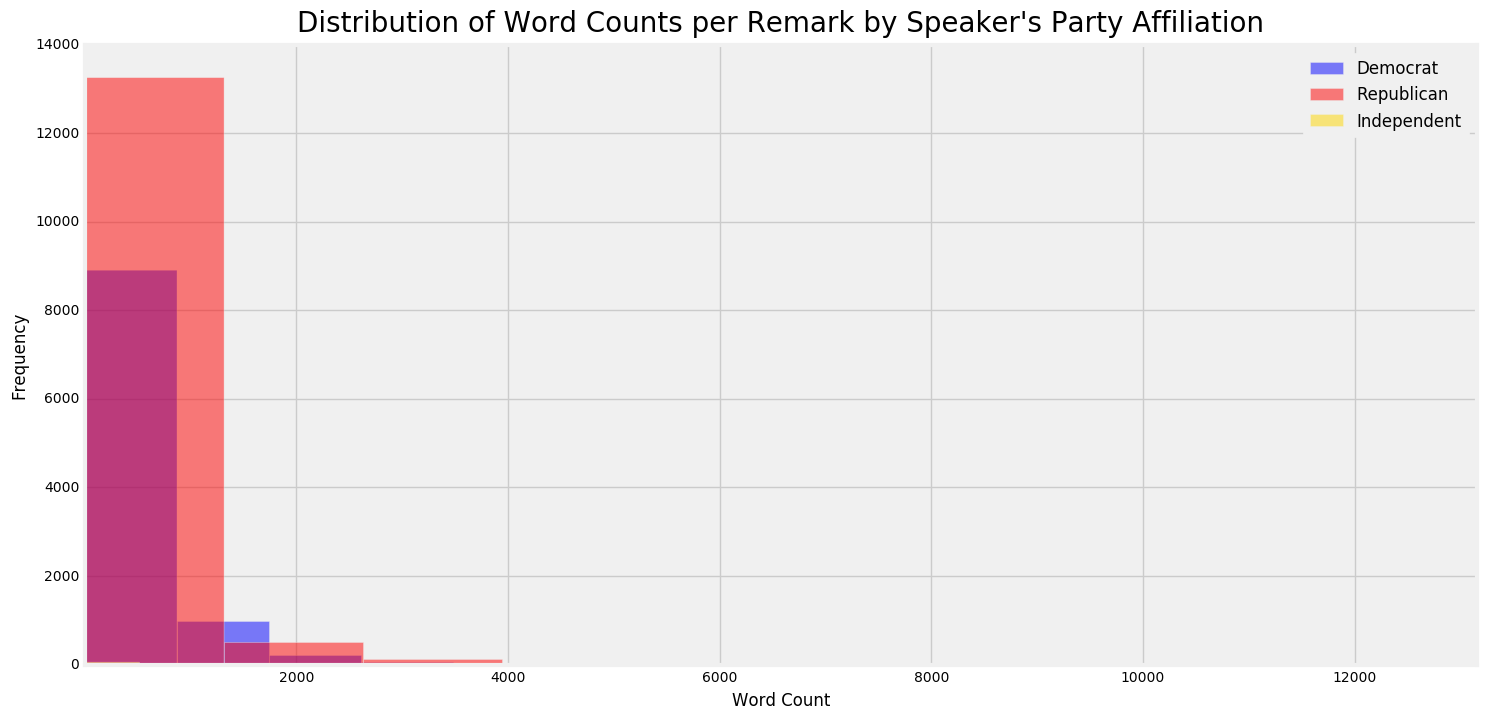

In [15]:
plt.figure(figsize = (16, 8))
df.loc[df['party'] == 'D', 'word_count'].hist(color = 'blue', alpha = .5, label = 'Democrat')
df.loc[df['party'] == 'R', 'word_count'].hist(color = 'red', alpha = .5, label = 'Republican')
df.loc[df['party'] == 'I', 'word_count'].hist(color = 'gold', alpha = .5, label = 'Independent')
plt.title('Distribution of Word Counts per Remark by Speaker\'s Party Affiliation', fontsize = 20, y = 1.01)
plt.xlabel('Word Count')
plt.xlim([df['word_count'].min(), df['word_count'].max()])
plt.ylabel('Frequency')
plt.legend(loc = 'best')

In [118]:
max(df['word_count'])

13155

In [119]:
df.loc[df['word_count'] == 13155, :]

,title,speaker,remark,speaker_encoded,word_count,compound,neg,neu,pos,diff,reading_ease,grade_level,gender,party,target
10850,TRADE ACT OF 2015--Continued The PRESIDING OFF...,Mr. CRUZ.,"Mr. President, for many months I have been spe...",67,13155,0.9998,0.096,0.793,0.112,0.016,64.71,8.0,0.0,R,1


In [120]:
df['remark'][10850]

"Mr. President, for many months I have been speaking about what I call the Washington cartel. The Washington cartel consists of career politicians in both parties who get in bed with lobbyists and special interests in Washington and grow and grow and grow government. I believe the Washington cartel is the source of the volcanic frustration Americans face across this country, and it is difficult to find a better illustration of the Washington cartel than the charade we are engaged in this evening. This deal we are here to vote on is both shockingly bad on the merits and it is also a manifestation of the bipartisan corruption that suffuses Washington, DC. What are the terms of this budget deal? Well, in short, what the House of Representatives has passed, and what the Senate is expected to pass shortly, is a bill that adds $85 billion in spending increases--$85 billion to our national debt, $85 billion to your children and my children that they are somehow expected to pay. I don't know a

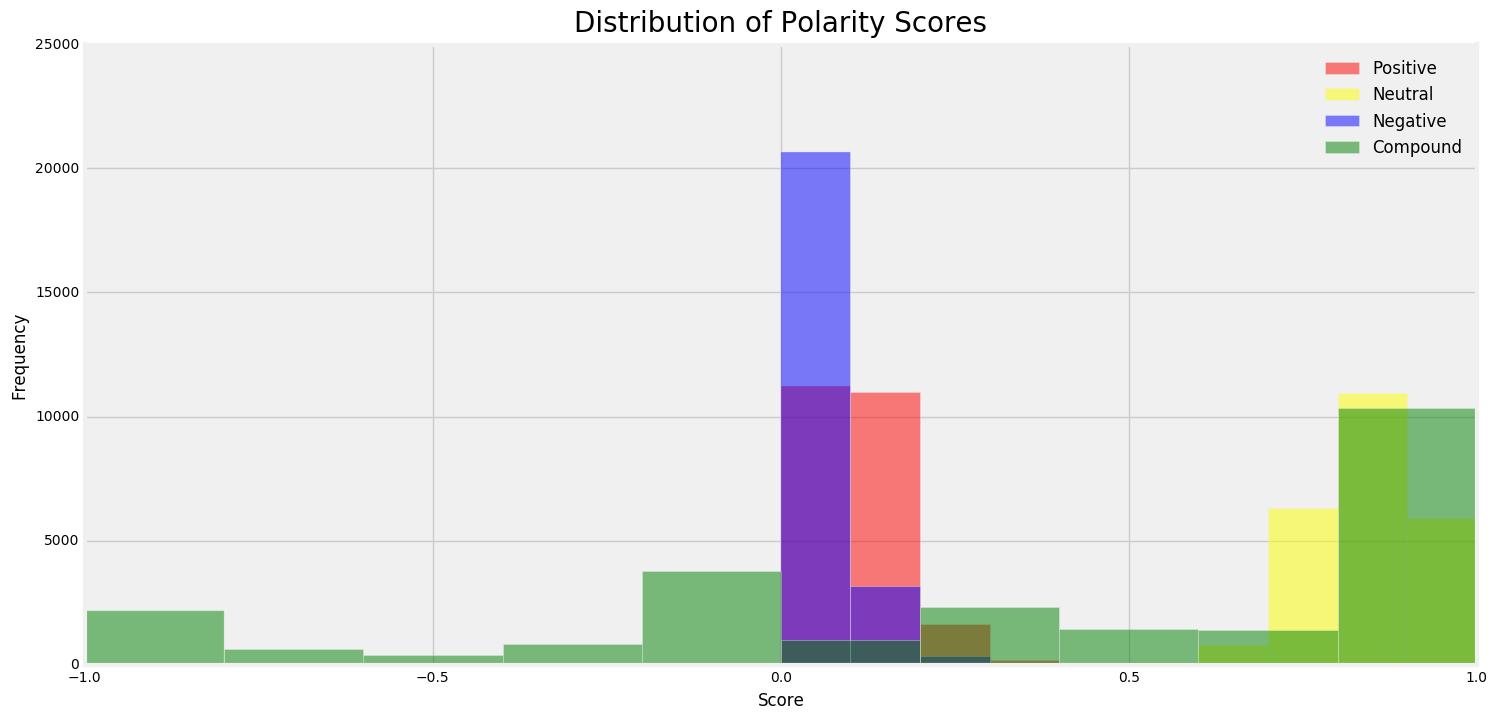

In [16]:
plt.figure(figsize = (16, 8))
df['pos'].hist(color = 'red', alpha = .5, label = 'Positive')
df['neu'].hist(color = 'yellow', alpha = .5, label = 'Neutral')
df['neg'].hist(color = 'blue', alpha = .5, label = 'Negative')
df['compound'].hist(color = 'green', alpha = .5, label = 'Compound')
plt.title('Distribution of Polarity Scores', fontsize = 20, y = 1.01)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc = 'best')

In [17]:
colors = {'R':'red', 'D':'blue', 'I':'gold'}

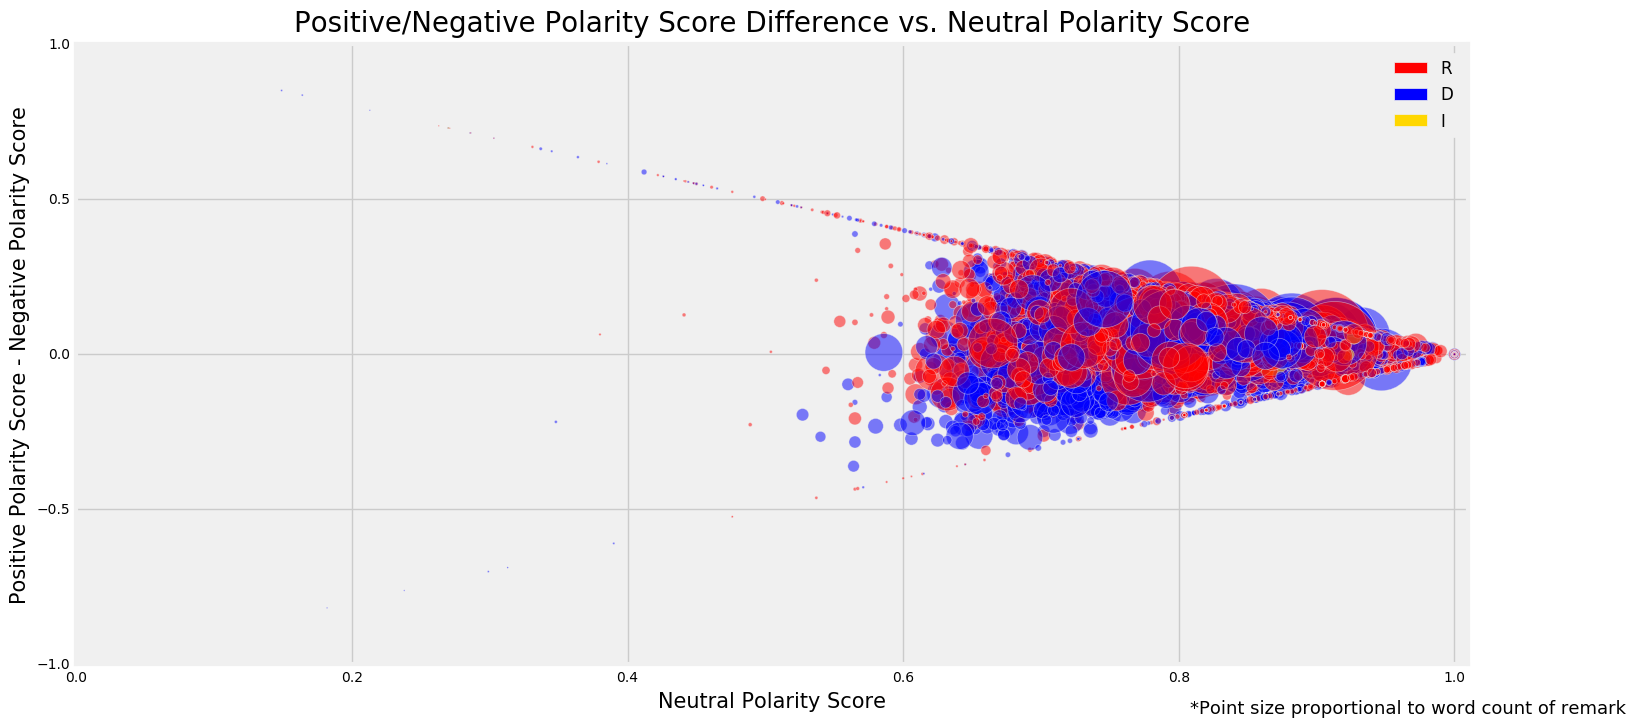

In [18]:
plt.figure(figsize = (16, 8))
plt.title('Positive/Negative Polarity Score Difference vs. Neutral Polarity Score', fontsize = 20, y = 1.01)
plt.xlabel('Neutral Polarity Score', fontsize = 15)
plt.xlim([df['neu'].min(), 1.01])
plt.ylabel('Positive Polarity Score - Negative Polarity Score', fontsize = 15)
plt.ylim([df['diff'].min(), df['diff'].max()])

x = df['neu']
y = df['diff']
area = df['word_count'] * .5

parties = ['R', 'D', 'I']
colors_list = ['red','blue','gold']

recs = []
for i in range(0,len(colors_list)):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc = colors_list[i]))
plt.legend(recs, parties, loc = 'best')

plt.annotate('*Point size proportional to word count of remark', (1,0), (-200, -25), \
             xycoords = 'axes fraction', textcoords = 'offset points', va = 'top', fontsize = 13)

plt.scatter(x, y, s = area, c = df['party'].apply(lambda x: colors[x]), alpha = 0.5)

plt.show()

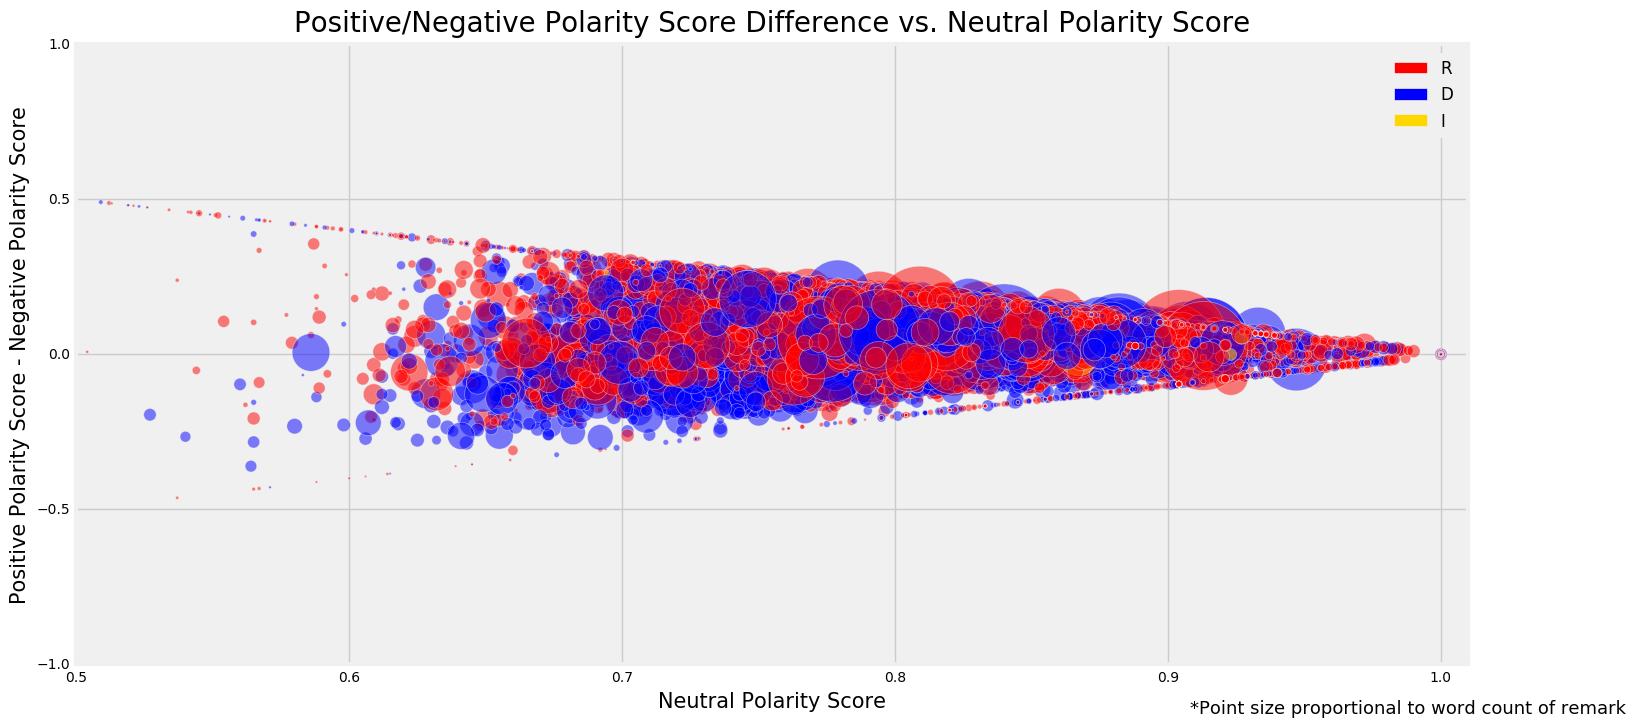

In [19]:
plt.figure(figsize = (16, 8))
plt.title('Positive/Negative Polarity Score Difference vs. Neutral Polarity Score', fontsize = 20, y = 1.01)
plt.xlabel('Neutral Polarity Score', fontsize = 15)
plt.xlim([.5, 1.01])
plt.ylabel('Positive Polarity Score - Negative Polarity Score', fontsize = 15)
plt.ylim([df['diff'].min(), df['diff'].max()])

x = df['neu']
y = df['diff']
area = df['word_count'] * .5

parties = ['R', 'D', 'I']
colors_list = ['red','blue','gold']

recs = []
for i in range(0,len(colors_list)):
    recs.append(mpatches.Rectangle((0, 0), 1, 1, fc = colors_list[i]))
plt.legend(recs, parties, loc = 'best')

plt.annotate('*Point size proportional to word count of remark', (1,0), (-200, -25), \
             xycoords = 'axes fraction', textcoords = 'offset points', va = 'top', fontsize = 13)

plt.scatter(x, y, s = area, c = df['party'].apply(lambda x: colors[x]), alpha = 0.5)
plt.show()

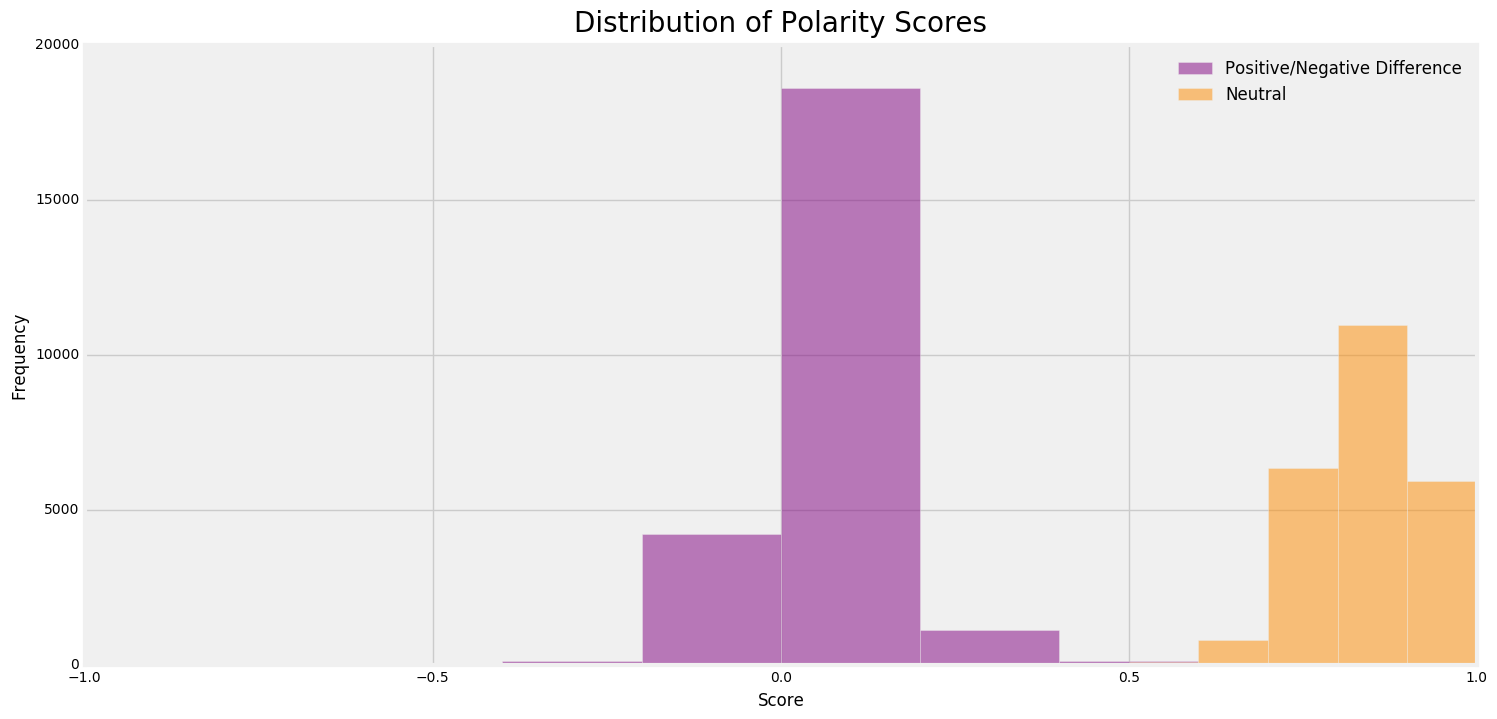

In [20]:
plt.figure(figsize = (16, 8))
df['diff'].hist(color = 'purple', alpha = .5, label = 'Positive/Negative Difference')
df['neu'].hist(color = 'darkorange', alpha = .5, label = 'Neutral')
plt.title('Distribution of Polarity Scores', fontsize = 20, y = 1.01)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc = 'best')

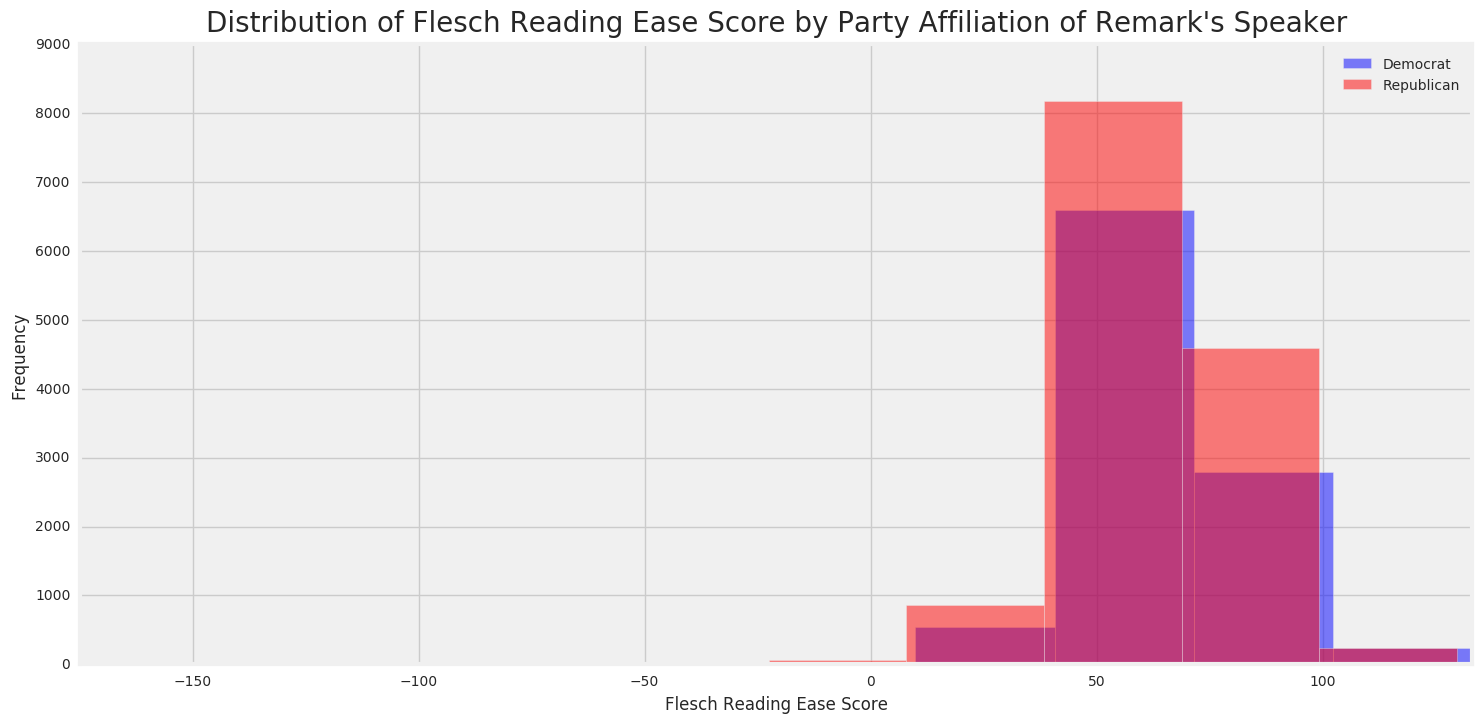

In [117]:
plt.figure(figsize = (16, 8))
df.loc[df['party'] == 'D', 'reading_ease'].hist(color = 'blue', alpha = .5, label = 'Democrat')
df.loc[df['party'] == 'R', 'reading_ease'].hist(color = 'red', alpha = .5, label = 'Republican')
plt.title('Distribution of Flesch Reading Ease Score by Party Affiliation of Remark\'s Speaker', fontsize = 20, y = 1.01)
plt.xlabel('Flesch Reading Ease Score')
plt.xlim([df['reading_ease'].min(), df['reading_ease'].max()])
plt.ylabel('Frequency')
plt.legend(loc = 'best')

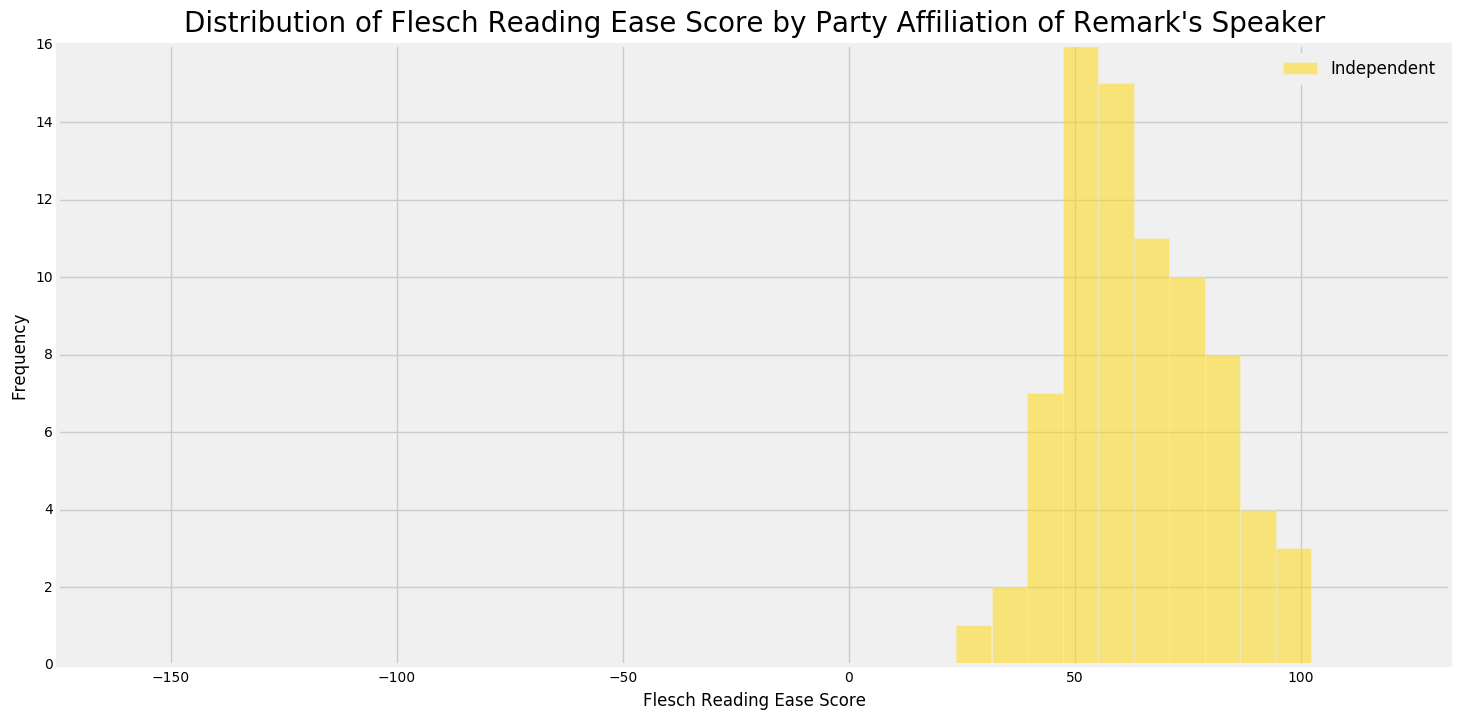

In [22]:
plt.figure(figsize = (16, 8))
df.loc[df['party'] == 'I', 'reading_ease'].hist(color = 'gold', alpha = .5, label = 'Independent')
plt.title('Distribution of Flesch Reading Ease Score by Party Affiliation of Remark\'s Speaker', fontsize = 20, y = 1.01)
plt.xlabel('Flesch Reading Ease Score')
plt.xlim([df['reading_ease'].min(), df['reading_ease'].max()])
plt.ylabel('Frequency')
plt.legend(loc = 'best')

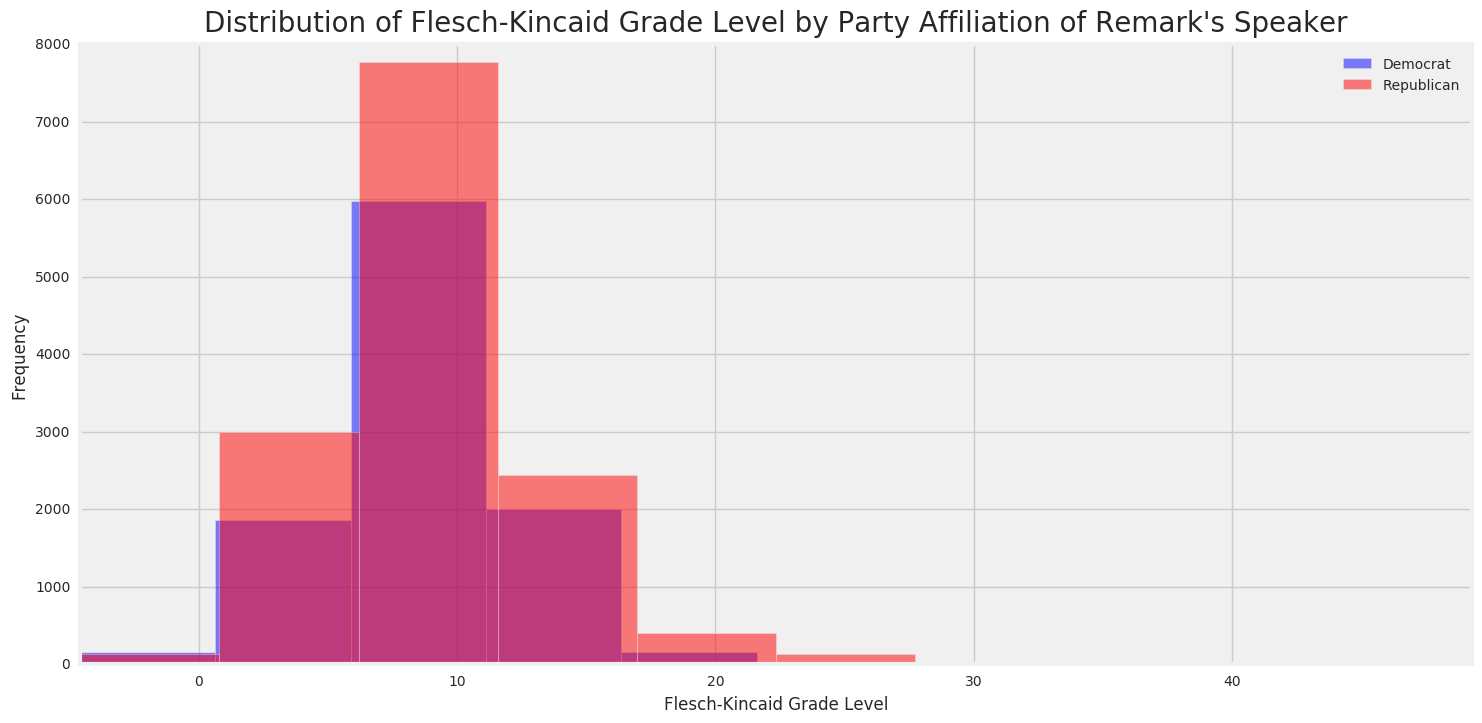

In [115]:
plt.figure(figsize = (16, 8))
df.loc[df['party'] == 'D', 'grade_level'].hist(color = 'blue', alpha = .5, label = 'Democrat')
df.loc[df['party'] == 'R', 'grade_level'].hist(color = 'red', alpha = .5, label = 'Republican')
plt.title('Distribution of Flesch-Kincaid Grade Level by Party Affiliation of Remark\'s Speaker', fontsize = 20, y = 1.01)
plt.xlabel('Flesch-Kincaid Grade Level')
plt.xlim([df['grade_level'].min(), df['grade_level'].max()])
plt.ylabel('Frequency')
plt.legend(loc = 'best')

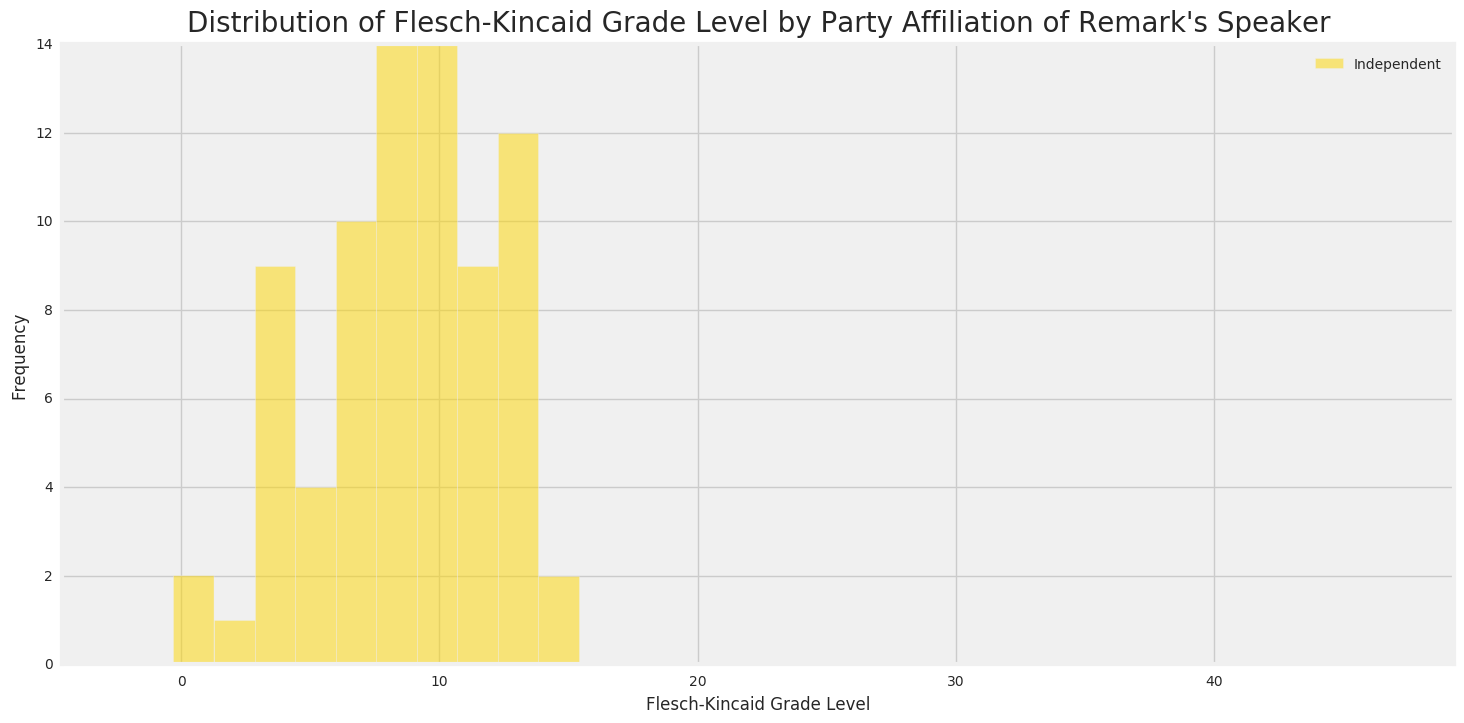

In [116]:
plt.figure(figsize = (16, 8))
df.loc[df['party'] == 'I', 'grade_level'].hist(color = 'gold', alpha = .5, label = 'Independent')
plt.title('Distribution of Flesch-Kincaid Grade Level by Party Affiliation of Remark\'s Speaker', fontsize = 20, y = 1.01)
plt.xlabel('Flesch-Kincaid Grade Level')
plt.xlim([df['grade_level'].min(), df['grade_level'].max()])
plt.ylabel('Frequency')
plt.legend(loc = 'best')

### HIERARCHICAL AGLOMERATIVE CLUSTERING (without outliers)

In [25]:
cluster_features = df.drop(['title', 'speaker', 'remark', 'speaker_encoded', 'target'], axis = 1)

In [26]:
cluster_features = pd.get_dummies(cluster_features)

In [27]:
cluster_df = pd.concat([cluster_features, vectored], axis = 1)

In [64]:
cluster_df.shape

(24209, 10488)

In [28]:
cluster_no_outs = cluster_df[(np.abs(stats.zscore(cluster_df)) < 3).all(axis = 1)]

In [73]:
cluster_no_outs = cluster_no_outs.reset_index(drop = True)
cluster_no_outs.shape

(1182, 10488)

In [30]:
cluster_no_outs.head()

,word_count,compound,neg,neu,pos,diff,reading_ease,grade_level,gender,party_D,...,youngest,youth,youtube,zealand,zeldin,zero,zika,zip,zone,zones
15,5,0.0000,0.00,1.000,0.000,0.000,91.78,1.7,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
186,7,0.2263,0.00,0.725,0.275,0.275,47.45,8.4,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
232,5,0.0000,0.00,1.000,0.000,0.000,91.78,1.7,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
238,13,-0.2960,0.18,0.820,0.000,-0.180,90.77,2.1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
261,12,0.3182,0.00,0.813,0.187,0.187,107.69,-0.3,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
X = MinMaxScaler().fit_transform(cluster_no_outs)

In [32]:
start = datetime.datetime.now()
print start

Z = linkage(X, 'ward')

print datetime.datetime.now() - start

2017-04-17 02:11:27.709474
0:00:08.972172


In [33]:
c, coph_dists = cophenet(Z, pdist(X))
c

0.42933164744662189

In [34]:
Z[0]

array([  0.,  11.,   0.,   2.])

In [35]:
Z[1]

array([  86.,  116.,    0.,    2.])

In [36]:
Z[-1]

array([ 2360.        ,  2361.        ,    33.13415076,  1182.        ])

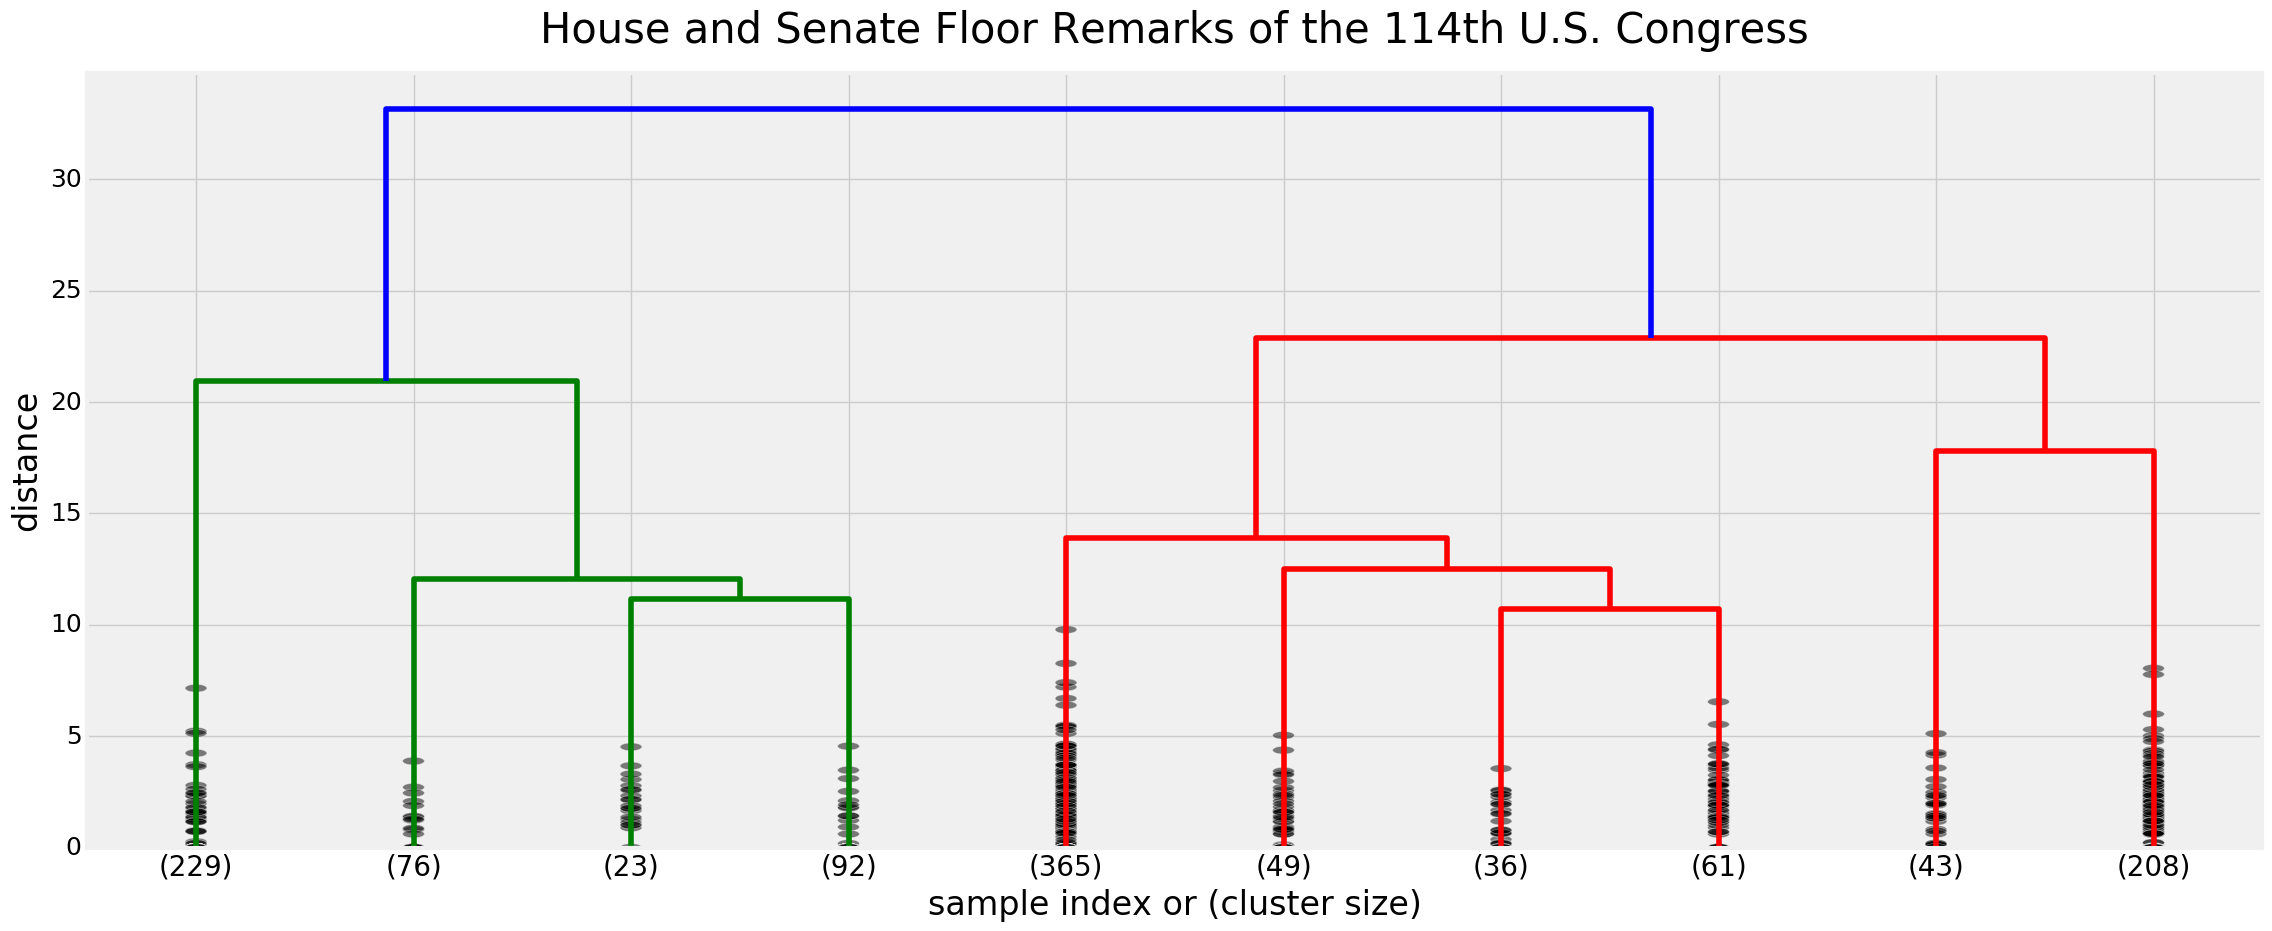

In [37]:
plt.figure(figsize = (25, 10))
plt.title('House and Senate Floor Remarks of the 114th U.S. Congress', fontsize = 30, y = 1.03)
plt.xlabel('sample index or (cluster size)', fontsize = 24)
plt.ylabel('distance', fontsize = 24)
plt.yticks(fontsize = 18)
dendrogram(
    Z,
    truncate_mode = 'lastp',  # only show cluster merges after there are p clusters
    p = 10,  # choose p
    show_leaf_counts = True,  
    leaf_rotation = 0,
    leaf_font_size = 20.,
    show_contracted = True,  # shows marks where previous splits would've branched if not for truncation
)
plt.show()

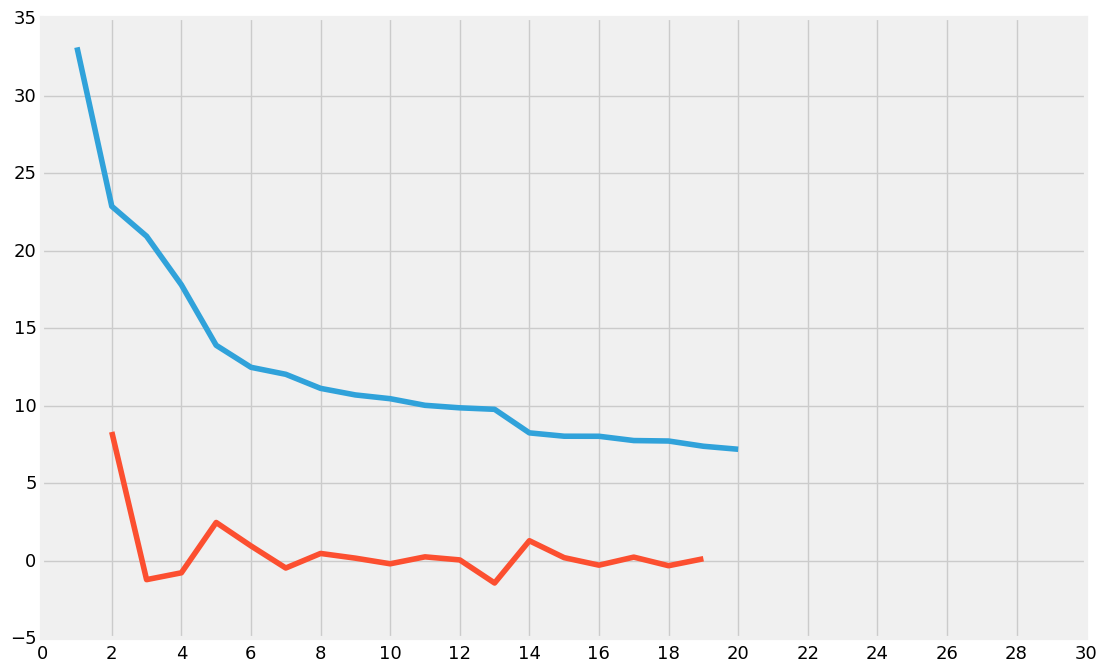

clusters: 2


In [38]:
plt.figure(figsize = (12, 8))

last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)

plt.yticks(fontsize = 13)
plt.xticks(range(0, 32, 2), fontsize = 13)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k

In [40]:
k = 5
k_clusters = fcluster(Z, k, criterion = 'maxclust')
k_clusters

array([5, 4, 3, ..., 3, 2, 4], dtype=int32)

In [44]:
pca = PCA().fit(X)

In [45]:
pca_df = pd.DataFrame(zip(pca.components_, pca.explained_variance_/sum(pca.explained_variance_)), \
                      columns = ['eigenvector', 'eigenvalue'])

pca_df.head()

,eigenvector,eigenvalue
0,"[0.0373366483217, 0.0241573874492, -0.00422533...",0.178609
1,"[-0.00199249591082, 0.00740180361378, -0.01554...",0.164062
2,"[0.106514279994, 0.0650428798516, -0.017745976...",0.061992
3,"[-0.0575911350027, 0.0854290790189, 0.04721186...",0.051507
4,"[0.188876288152, 0.164575361433, -0.0049404489...",0.037303


In [49]:
pca_df.loc[0:3, 'eigenvalue'].sum()

0.45616974275546035

In [59]:
X_pca = pd.DataFrame(np.dot(pca.components_[0:3], X.T)).T
X_pca.columns = ['PC1', 'PC2', 'PC3']

X_pca['labels'] = k_clusters
X_pca.head(2)

,PC1,PC2,PC3,labels
0,0.541262,0.453263,-0.283731,5
1,-0.278833,-0.468196,0.955782,4


In [60]:
X_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 4 columns):
PC1       1182 non-null float64
PC2       1182 non-null float64
PC3       1182 non-null float64
labels    1182 non-null int32
dtypes: float64(3), int32(1)
memory usage: 32.4 KB


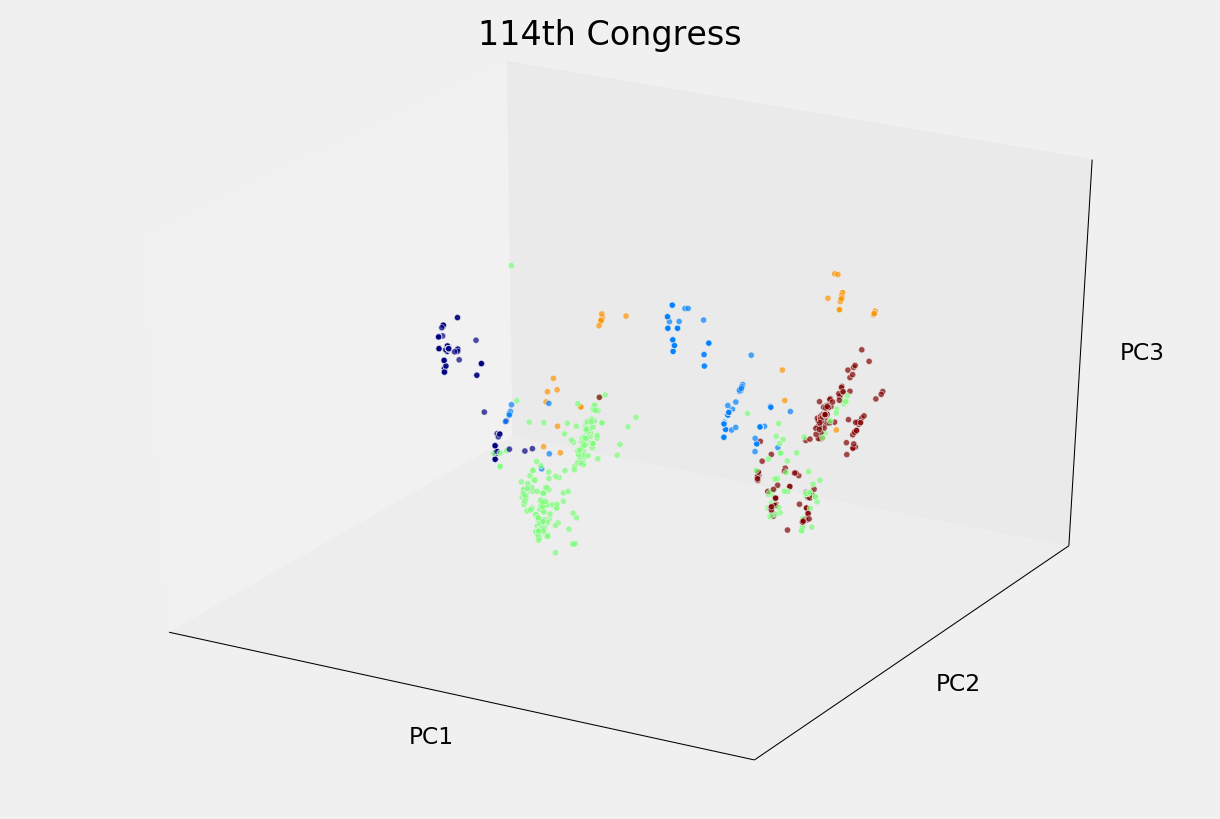

In [61]:
fig = pylab.figure(figsize = (12, 8))
ax = Axes3D(fig)

ax.scatter(X_pca['PC1'], X_pca['PC2'], X_pca['PC3'], zdir='z', alpha=.7, c = k_clusters, cmap = 'jet')

ax.set_title("114th Congress", fontsize = 24, y = 1.03)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

In [77]:
mama_df = pd.DataFrame()
for i in range(1, k + 1):
    young_cluster = cluster_no_outs[k_clusters == i]
    length = len(young_cluster)
    young_df = pd.DataFrame(young_cluster.sum()/len(young_cluster), columns = ['cluster{}'.format(i)])
    mama_df = pd.concat([mama_df, young_df], axis = 1)

In [79]:
mama_df.head()

,cluster1,cluster2,cluster3,cluster4,cluster5
word_count,9.620087,11.214660,11.238748,12.232558,11.384615
compound,0.016781,0.057348,0.032319,0.230423,0.050012
neg,0.000000,0.000000,0.006057,0.002488,0.000000
neu,0.991882,0.978445,0.974714,0.819674,0.981337
pos,0.008118,0.021555,0.019227,0.177837,0.018663


In [81]:
mama_df.shape

(10488, 5)

In [ ]:
plt.figure(figsize = (15, 20))
sns.heatmap(mama_df.T, cmap = 'coolwarm')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

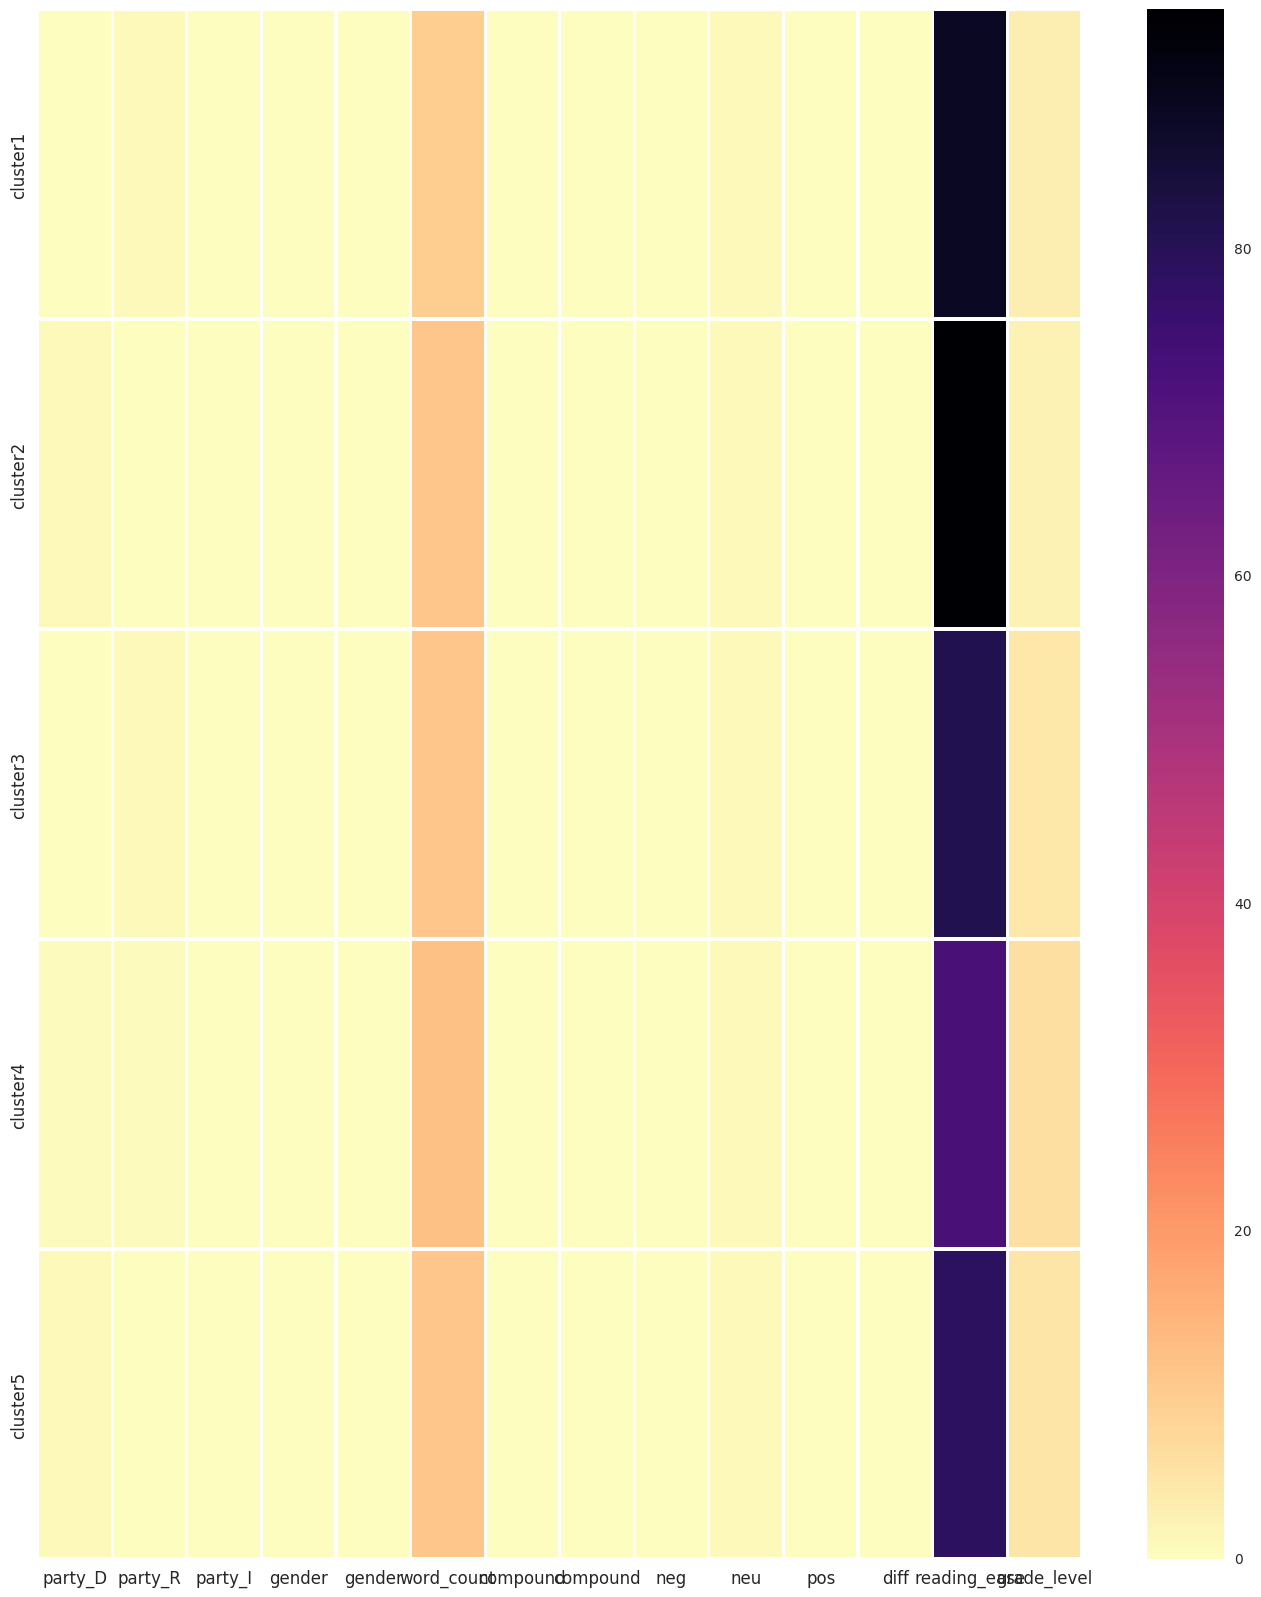

In [89]:
plt.figure(figsize = (15, 20))
sns.heatmap(mama_df.T[
        ['party_D', 'party_R', 'party_I', 'gender', 'word_count', 'compound', 'neg', 'neu', 'pos', 'diff', 'reading_ease', 'grade_level']
                    ], cmap = 'magma_r', linewidths = 1.5, linecolor = 'white')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

### PREDICTIVE MODEL

In [96]:
model_df = cluster_df.drop(['diff'], axis = 1)

X = MinMaxScaler().fit_transform(model_df)
y = df['target']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2)

In [98]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
y_hat = xgbc.predict(X_test)

In [99]:
accuracy_score(y_test, y_hat)

0.99086243584929279

In [111]:
model_df = cluster_df.drop(['compound', 'neg', 'neu', 'pos', 'diff'], axis = 1)

X = MinMaxScaler().fit_transform(model_df)
y = df['target']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 2)

In [113]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
y_hat = xgbc.predict(X_test)

In [114]:
accuracy_score(y_test, y_hat)

0.8509200150206534

### RAINY DAY CODE

In [ ]:
# import requests

# PROPUBLICA CONGRESS API
# key = {'X-API-Key': 'ooZoJpm3DF5xfmy21jXuE8u4qOEuR6oM5LTfrMsP'}
# r_house = requests.get('https://api.propublica.org/congress/v1/114/house/members.json', headers = key)
# r_senate = requests.get('https://api.propublica.org/congress/v1/114/senate/members.json', headers = key)

# results_h = []
# results_s = []

# results_h.append(r_house.json().values())
# results_s.append(r_senate.json().values())

# house = results_h[0][1][0]
# senate = results_s[0][1][0]

# house_df = pd.DataFrame(house.get('members'), columns = ['last_name', 'first_name', 'middle_name', 'party', 'state', 
#                                                          'district', 'leadership_role', 'seniority', 'missed_votes', 
#                                                          'missed_votes_pct', 'total_present', 'total_votes', 
#                                                          'votes_with_party_pct'
#                                                         ]
#                         )
# senate_df = pd.DataFrame(senate.get('members'), columns = ['last_name', 'first_name', 'middle_name', 'party', 'state', 
#                                                          'district', 'leadership_role', 'seniority', 'missed_votes', 
#                                                          'missed_votes_pct', 'total_present', 'total_votes', 
#                                                          'votes_with_party_pct'
#                                                         ]
#                         )

# c114_members = pd.concat([house_df, senate_df], axis = 0)

In [ ]:
# from nltk.stem.snowball import SnowballStemmer
# from nltk.tag import pos_tag

# stemmer = SnowballStemmer("english", ignore_stopwords = False)
# df['stemmed'] = stemmer.stem(df['remark'])
# df['stemmed'] = df['remark'].apply(lambda x: [stemmer.stem(x) for x in df['remark']])

In [ ]:
# fig, ax1 = plt.subplots(figsize = (12, 8))

# data = []
# for i in range(1, 7):
#     data.append(cluster_no_outs.loc[k_clusters == i, 'word_count'])

# plt.boxplot(data, 0, 'gD')

# ax1.yaxis.grid(True, linestyle = '-', which = 'major', color = 'lightgrey',
#                alpha = 0.5)

# ax1.set_axisbelow(True)
# ax1.set_title('114th Congress Clusters', y = 1.03, fontsize = 24)
# ax1.set_xlabel('Cluster', fontsize = 20)
# ax1.set_ylabel('Word Count', fontsize = 20)

# # Set the axes ranges and axes labels
# numBoxes = k
# ax1.set_xlim(0.5, numBoxes + 0.5)
# ax1.set_ylim(0, 1)
# xtickNames = plt.setp(ax1, xticklabels = range(1, 7))
# plt.setp(xtickNames, fontsize = 20)
# ytickNames = plt.setp(ax1, yticklabels = [])
# plt.setp(ytickNames, fontsize = 14)

# plt.axhline(0, color = 'black', alpha = 0.5)

# del data

# plt.show()

In [ ]:
# REGEX GRAVEYARD
# r'(?i)Mr*s*\.\s\w*(\s\w* of \w*)*\.'

# Jocelyn's regex: 'Mr*s*\.\s[^(Speaker)(President)(Chair)(Chairman)(Chairwoman)(Leader)(Majority Leader)(Minority Leader)]\w*'
# Mine: '(Mr\.|Mrs\.|Ms\.)\s[^(Speaker)(President)(Chair)(Chairman)(Chairwoman)(Leader)(Majority Leader)(Minority Leader)]\w*(\s\w*)?'
# Also mine: 'Mr*s*\.\s[^(Speaker)(President)(Chair)(Chairman)(Chairwoman)(Leader)(Majority Leader)(Minority Leader)]\w.*?\.'

# 'Mr*s*\.\s^/(?!Speaker|President|Chair|Chairwoman|Chairman|Leader|Minority Leader|Majority Leader)\w.*?\.'

# Previous regex: 'Mr*s*\.\s(?!Speaker|President|Chair|Chairman|Chairwoman|Leader|Majority Leader|Minority Leader)\w*'

# Best hope: 'Mr*s*\.\s[A-Z]+\w*(\s\w* of \w*)*\.'